# Выбор локации для бурения для 3 регионов

## Описание данных и целей проекта

Компания «ГлавРосГосНефть» стремится оптимизировать процесс выбора мест для бурения нефтяных скважин. Задача заключается в анализе данных геологоразведки и построении модели для определения региона, который принесёт наибольшую прибыль при разработке.  

В ходе проекта требуется решить несколько ключевых задач:
1. **Построение модели предсказания запасов нефти в скважинах.**  
   Для каждого из трёх регионов необходимо создать модель, которая будет прогнозировать объём запасов на основе предоставленных данных.

2. **Оценка возможной прибыли и рисков.**  
   На основе предсказаний модели и экономических условий требуется рассчитать прибыль от разработки скважин в каждом регионе. Анализ рисков с помощью бутстрепа поможет выявить наиболее перспективные регионы.

3. **Определение лучшего региона для разработки.**  
   По результатам анализа необходимо выбрать регион, где разработка скважин принесёт максимальную прибыль с минимальным уровнем риска.

### Описание данных
Данные геологоразведки предоставлены для трёх регионов, каждый из которых представлен отдельным набором.  

Каждый датасет содержит следующие признаки:
- `id` — уникальный идентификатор скважины.
- `f0`, `f1`, `f2` — численные признаки, описывающие характеристики точки.
- `product` — объём запасов в скважине (тыс. баррелей).

### Цели анализа
1. Построить модели машинного обучения для прогнозирования объёма запасов нефти.
2. Провести исследовательский анализ данных для выявления особенностей каждого региона.
3. Определить уровень рентабельности и рисков для каждого региона.
4. Выбрать регион, который принесёт наибольшую прибыль при разработке.

### Условия задачи
- Разведка проводится в 500 точках каждого региона, из которых будет выбрано 200 лучших для разработки.
- Бюджет на разработку региона составляет 10 млрд рублей.
- Доход с каждой тысячи баррелей нефти составляет 450 тыс. рублей.
- Для оценки рисков необходимо определить вероятность убытков. Допустимый уровень риска — не более 2.5%.

### Этапы работы
Для достижения целей проекта работа будет организована следующим образом:

**Этап 1: Загрузка и первичный анализ данных**  
- Загрузить данные.  
- Проверить корректность структуры, наличие пропусков и аномалий.  

**Этап 2: Обучение моделей**  
- Разделить данные каждого региона на обучающую и валидационную выборки (75:25).  
- Построить линейную регрессионную модель для каждого региона.  
- Оценить средний объём запасов и RMSE на валидационных данных.  

**Этап 3: Анализ прибыли**  
- Рассчитать достаточный объём нефти для безубыточности.  
- Сравнить средние прогнозируемые запасы нефти с этим порогом.  
- Оценить прибыль от разработки лучших 200 скважин.  

**Этап 4: Оценка рисков**  
- Применить бутстреп для анализа распределения прибыли.  
- Рассчитать среднюю прибыль, доверительный интервал и вероятность убытков.  

**Этап 5: Выбор региона**  
- Сравнить регионы по средней прибыли и уровню риска.  
- Выбрать регион с максимальной прибылью при минимальном риске.  

### Ожидаемые результаты
- Модель, способная предсказывать объём запасов нефти с высокой точностью.  
- Анализ рисков и прибыли для каждого региона.  
- Рекомендация для компании по выбору наиболее перспективного региона для разработки.  

Этот проект позволит компании «ГлавРосГосНефть» минимизировать риски и получить максимальную прибыль от новых скважин.


## Предварительная обработка данных

**Подгрузка библиотек и полезных функций**

In [1]:
!pip install -q --upgrade scikit-learn
!pip install -q shap
!pip install -q phik
!pip install -q xgboost
!pip install -q lightgbm
!pip install -q catboost

In [2]:
import logging
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from catboost import CatBoostClassifier, CatBoostRegressor
from IPython.display import HTML, Markdown, display
from lightgbm import LGBMClassifier, LGBMRegressor
from matplotlib.colors import ListedColormap
from phik import phik_matrix, report, resources
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    GradientBoostingRegressor,
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    mutual_info_classif,
    mutual_info_regression,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    ElasticNet,
    Lasso,
    LinearRegression,
    LogisticRegression,
    Ridge,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.neighbors import (
    KNeighborsClassifier,
    KNeighborsRegressor,
    NearestNeighbors,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from tqdm import tqdm
from xgboost import XGBClassifier, XGBRegressor

plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
def col_display(text, color="black", bold=False, bgcolor=None):
    # Добавляем пробел в начале текста
    text = "'" + text

    # Стиль для текста
    style = f"color: {color};"

    # Добавление жирности, если нужно
    if bold:
        style += " font-weight: bold;"

    # Добавление фона, если указан
    if bgcolor:
        style += f" background-color: {bgcolor};"

    # Устанавливаем margin и padding, чтобы избежать обрезки текста
    style += " padding: 0; margin: 0; display: inline;"

    # Формируем HTML для вывода
    html_text = f"<div style='{style}'>{text}</div>"

    # Отображаем текст
    display(HTML(html_text))


def err_display(text):
    col_display("ERROR: " + text, color="white", bgcolor="red", bold=True)


def info_display(text):
    col_display("INFO: " + text, color="white", bgcolor="blue", bold=True)


def cycle_display(text):
    col_display("Текущая итерация: " + text, color="yellow", bold=True)


def final_display(text):
    col_display(text, color="green", bold=True)


def title_display(text):
    col_display(text, color="white", bgcolor="green", bold=True)

**Добавление исходных датасетов и их предварительная оценка**

In [4]:
# Импорты
import os

import pandas as pd

# Пути к файлам
local_paths = {
    "geo_data_0": "geo_data_0.csv",
    "geo_data_1": "geo_data_1.csv",
    "geo_data_2": "geo_data_2.csv",
}

server_paths = {
    "geo_data_0": "https://code.s3.yandex.net/datasets/geo_data_0.csv",
    "geo_data_1": "https://code.s3.yandex.net/datasets/geo_data_1.csv",
    "geo_data_2": "https://code.s3.yandex.net/datasets/geo_data_2.csv",
}


# Функция для загрузки данных с проверкой пути
def load_data_safely(
    name, local_path, server_path, sep=",", decimal=".", encoding="utf-8"
):
    """
    Загружает данные из файла, проверяя наличие локального пути или серверного.

    Параметры:
        name (str): Имя набора данных
        local_path (str): Локальный путь к файлу
        server_path (str): Серверный путь к файлу
        sep (str): Разделитель значений
        decimal (str): Разделитель десятичных значений
        encoding (str): Кодировка файла

    Возвращает:
        pd.DataFrame: Загруженный датафрейм с заданным именем
    """
    try:
        if os.path.exists(local_path):
            data = pd.read_csv(local_path, sep=sep, decimal=decimal, encoding=encoding)
            display(f"Успешно загружен файл {name} из локального пути: {local_path}")
        else:
            data = pd.read_csv(server_path, sep=sep, decimal=decimal, encoding=encoding)
            display(f"Успешно загружен файл {name} с сервера: {server_path}")
        return data
    except FileNotFoundError:
        display(f"Ошибка: Файл {name} не найден - {local_path} или {server_path}")
    except pd.errors.ParserError:
        display(f"Ошибка: Неправильный формат данных - {local_path} или {server_path}")
    except Exception as e:
        display(f"Неизвестная ошибка при загрузке {name}: {e}")


# Загрузка данных
datasets = {
    name: load_data_safely(name, local_paths[name], server_paths[name])
    for name in local_paths
}


# Проверка и обзор данных
def overview_data(data, name):
    """
    Отображает краткую информацию о датафрейме.

    Параметры:
        data (pd.DataFrame): Датафрейм для обзора
        name (str): Имя набора данных
    """
    if data is not None:
        display(f"\nИнформация о данных: {name}")
        display(data.head())
        data.info()
    else:
        display(f"Данные {name} не были загружены из-за ошибок.")


for name, data in datasets.items():
    overview_data(data, name)

geo_data_0 = datasets["geo_data_0"]
geo_data_1 = datasets["geo_data_1"]
geo_data_2 = datasets["geo_data_2"]

'Успешно загружен файл geo_data_0 с сервера: https://code.s3.yandex.net/datasets/geo_data_0.csv'

'Успешно загружен файл geo_data_1 с сервера: https://code.s3.yandex.net/datasets/geo_data_1.csv'

'Успешно загружен файл geo_data_2 с сервера: https://code.s3.yandex.net/datasets/geo_data_2.csv'

'\nИнформация о данных: geo_data_0'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'\nИнформация о данных: geo_data_1'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


'\nИнформация о данных: geo_data_2'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Вывод по предварительной обработке данных
- **Из предварительного анализа можно сделать следующие выводы:**
    1. Типы данных столбцов исходных таблиц изначально соответствуют содержанию. Их можно не менять
    2. Т.к из категориальных столбцов в исходных данных только `id`, в котором невозможно выделить неявные дубликаты, то имеет смысл проверять данные лишь на наличие явных
    3. Названия столбцов изначально являются оптимальными и не требуют изменения

**Анализ пропусков и явных дубликатов будет проведен после разделения данных на тренировочные и тестовые, непосредственно перед обучением моделей(Эти этапы предобработки можно выполнить только для тренировочных данных, т.к тестовые имитируют реальный рабочий поток, а значит не могут быть изменены.)**

## Исследовательский анализ данных

**Функция для вывода графиков распределения для всех столбцов данной таблицы**

In [5]:
def perform_exploratory_analysis(df):
    """
    Выполняет исследовательский анализ данных:
    1. Исключает столбец 'id' из анализа.
    2. Строит графики распределения количественных данных (гистограммы и боксплоты).
    3. Строит графики распределения дискретных и категориальных данных (столбчатые графики).
    4. Для 'salary' строит непрерывное распределение (гистограмма с KDE).
    """

    # Исключение столбца 'id', если он присутствует
    df = df.drop(columns=["id"], errors="ignore")

    # Определение типов столбцов
    quantitative_cols = df.select_dtypes(include=["float64"]).columns
    discrete_cols = df.select_dtypes(include=["int64"]).columns
    categorical_cols = df.select_dtypes(exclude=["float64", "int64"]).columns

    # Анализ количественных данных (непрерывные)
    if len(quantitative_cols) > 0:
        for col in quantitative_cols:

            # Общая логика для других количественных признаков
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))

            # Гистограмма с KDE
            sns.histplot(df[col], bins=20, kde=True, ax=axes[0], color="skyblue")
            axes[0].set_title(f"Гистограмма (с KDE): {col}")
            axes[0].set_xlabel(col)
            axes[0].set_ylabel("Частота")

            # Боксплот (Boxplot)
            sns.boxplot(x=df[col], ax=axes[1], color="lightblue")
            axes[1].set_title(f"Боксплот: {col}")
            axes[1].set_xlabel(col)

            # Настройка отображения
            plt.tight_layout()
            plt.show()

    # Анализ дискретных данных
    if len(discrete_cols) > 0:
        for col in discrete_cols:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=col, palette="Set3")
            plt.title(f"Распределение значений (дискретный признак): {col}")
            plt.xlabel(col)
            plt.ylabel("Частота")
            plt.xticks(rotation=45)
            plt.show()

    # Анализ категориальных данных
    if len(categorical_cols) > 0:
        for col in categorical_cols:
            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=col, palette="Set2")
            plt.title(f"Распределение значений (категориальный признак): {col}")
            plt.xlabel(col)
            plt.ylabel("Частота")
            plt.xticks(rotation=45)
            plt.show()

### Таблица для 0 месторождения

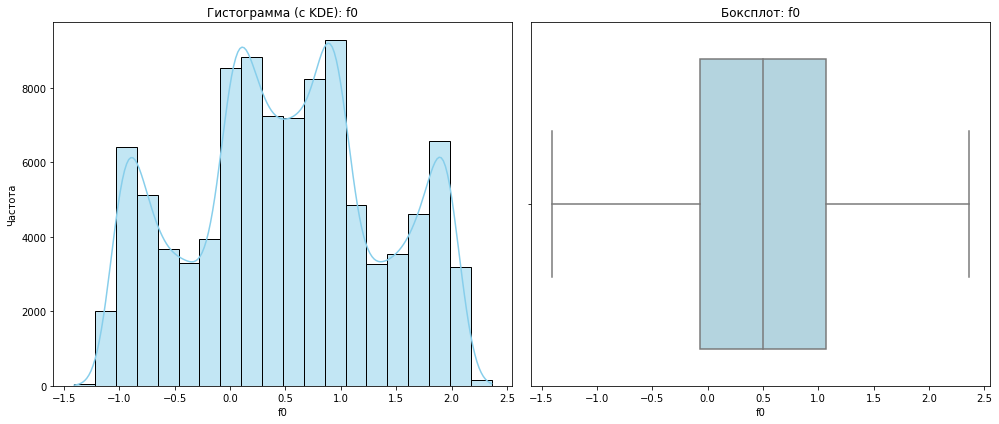

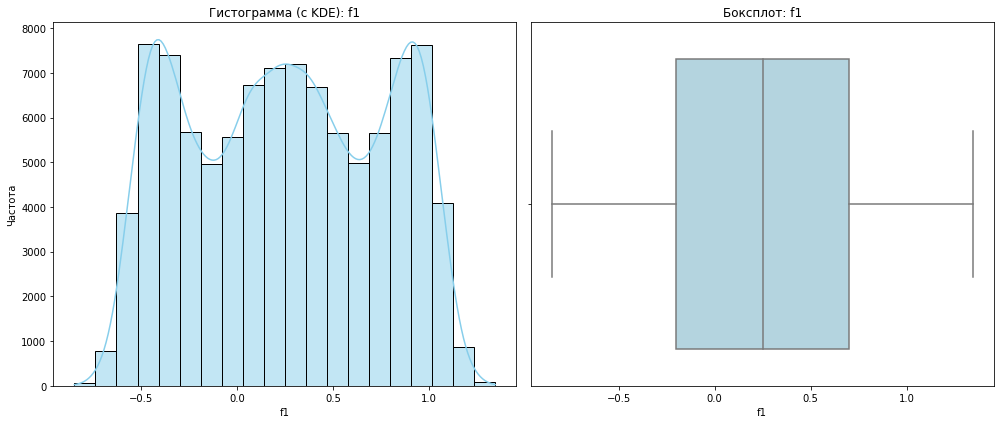

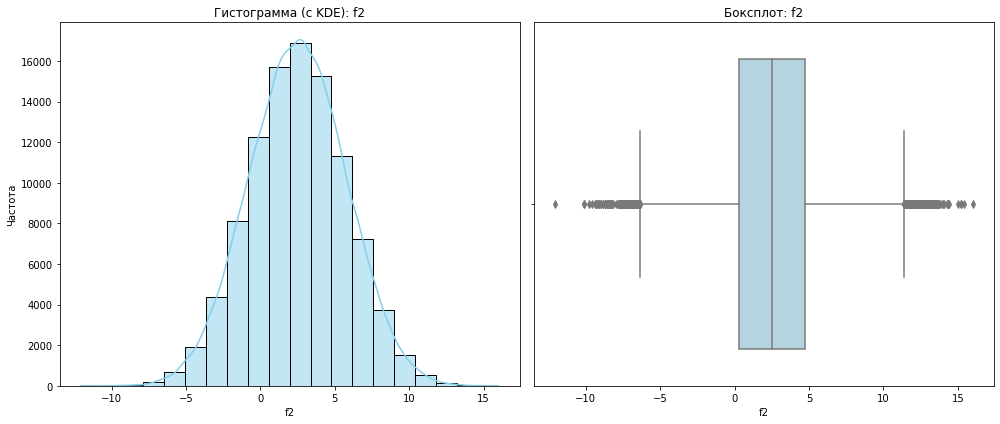

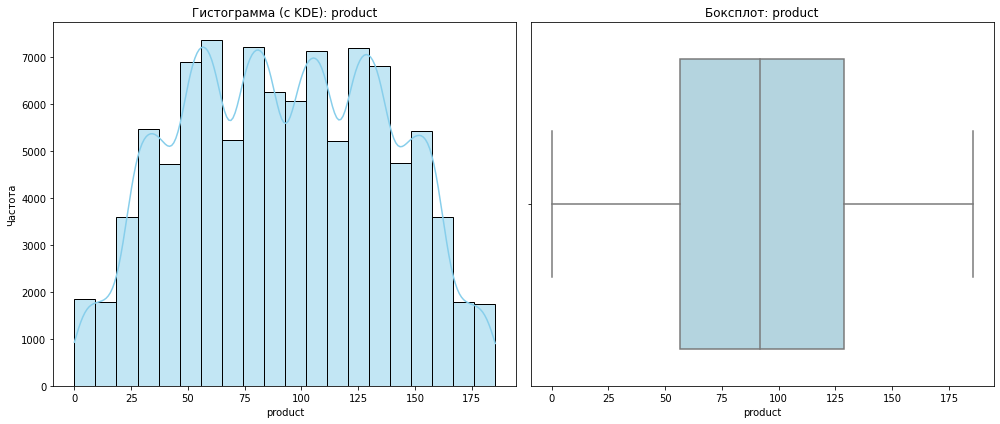

In [6]:
perform_exploratory_analysis(geo_data_0)

* **В распределениях для некоторых координат присутствует `мультимодальность`(многопиковость), что может говорить о влиянии таких факторов, как:**
    - Разные группы данных: Если пики хорошо отделены, возможно, данные представляют собой несколько групп (кластеров). Например, координаты для разных точек вычислялись разными геологами или разными методами.

    - Сезонность или периодичность: Если признак связан с периодическими изменениями (например, температура в течение года), то пики могут быть следствием этой периодичности.

    - Шум или аномалии: Дополнительные пики могут быть результатом выбросов, шумов или ошибок в данных.

**Вывели статистические данные по таблице**

In [7]:
# Выводим статистику для количественных столбцов
statistics = geo_data_0.select_dtypes(
    include=["float64", "int64"]
).describe()  # Статистические данные

# Выводим статистику
display(statistics)

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


**Статистические данные выглядят правдоподобно. Минимальное значение столбца `product` не является выбросом, а лишь указывает на отсутствие в этих точках нефти.**

### Таблица для 1 месторождения

**Столбцы `f2` И `product` в этой таблице имеют дискретное распределение. Поэтому привели их к целочисленному типу для вывода более корректных графиков**

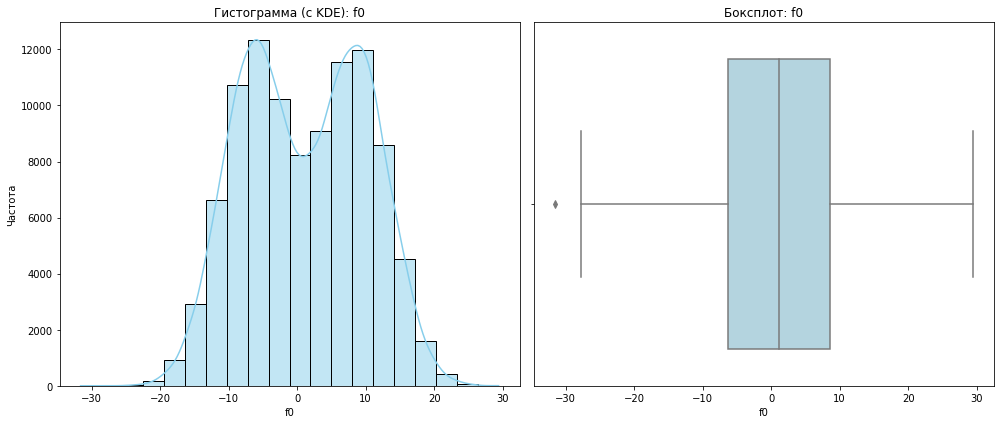

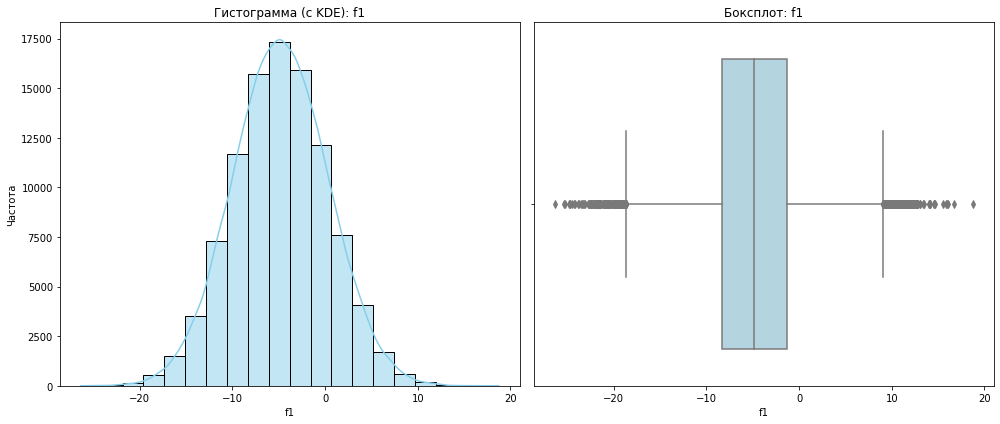

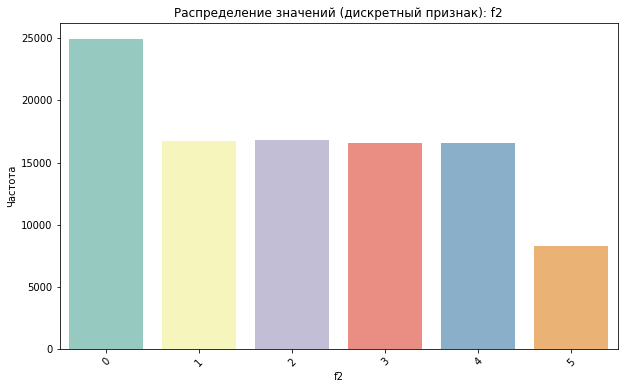

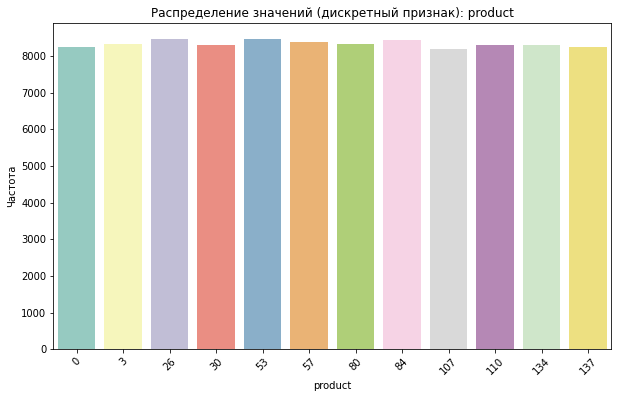

In [8]:
# Преобразование столбцов f2 и product к типу int
try:
    datasets["geo_data_1"]["f2"] = datasets["geo_data_1"]["f2"].astype(int)
    datasets["geo_data_1"]["product"] = datasets["geo_data_1"]["product"].astype(int)
    title_display("Столбцы 'f2' и 'product' успешно преобразованы в тип int.")
except ValueError as e:
    err_display(f"Ошибка преобразования типов: {e}")
except KeyError as e:
    err_display(f"Ошибка: столбец не найден - {e}")

perform_exploratory_analysis(geo_data_1)

**При написании и обучении моделей необходимо учесть дискретность распределений вышеуказанных столбцов. В остальном данные выглядят достаточно правдоподобно. В отличие от предыдущей таблицы здесь полностью отсутствует мультимодальность. Это различие может повлиять на конечную точность моделей**

**Вывели статистические данные по таблице**

In [9]:
# Выводим статистику для количественных столбцов
statistics = geo_data_1.select_dtypes(
    include=["float64", "int32"]
).describe()  # Статистические данные

# Выводим статистику
display(statistics)

,f0,f1
count,100000.000000,100000.000000
mean,1.141296,-4.796579
std,8.965932,5.119872
min,-31.609576,-26.358598
25%,-6.298551,-8.267985
50%,1.153055,-4.813172
75%,8.621015,-1.332816
max,29.421755,18.734063


**Статистические данные напоминают таковые из предыдущей таблицы**

### Таблица для 2 месторождения

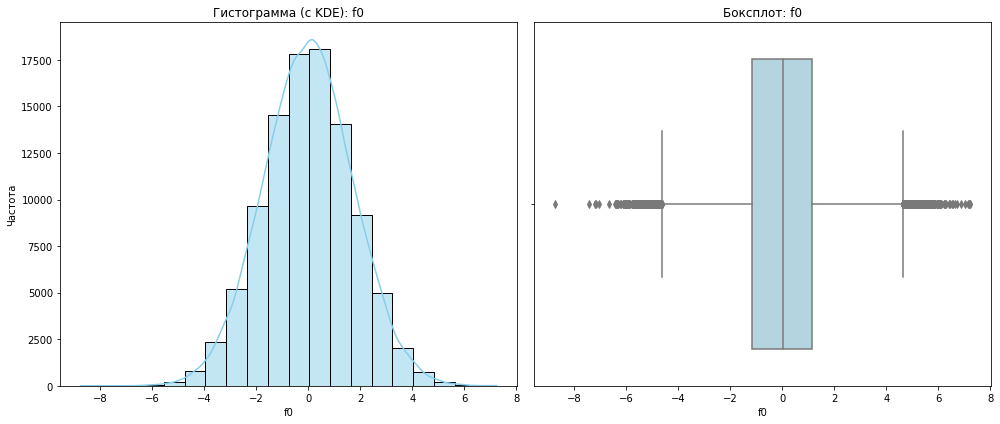

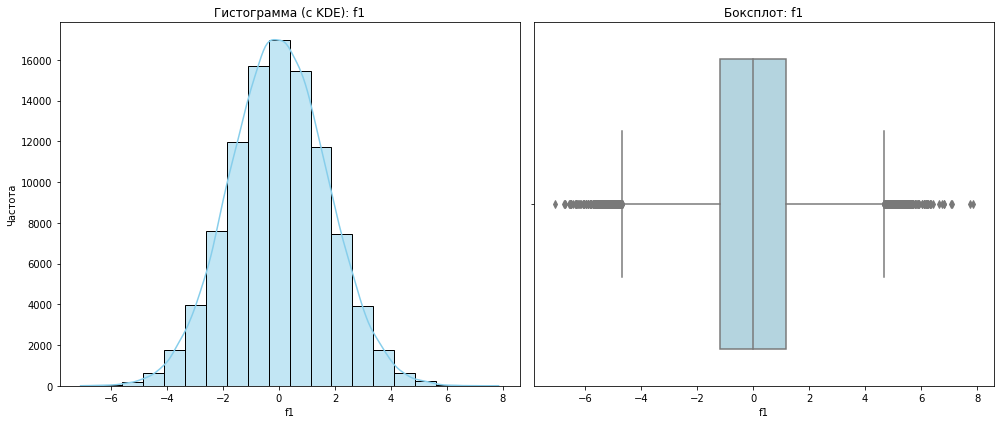

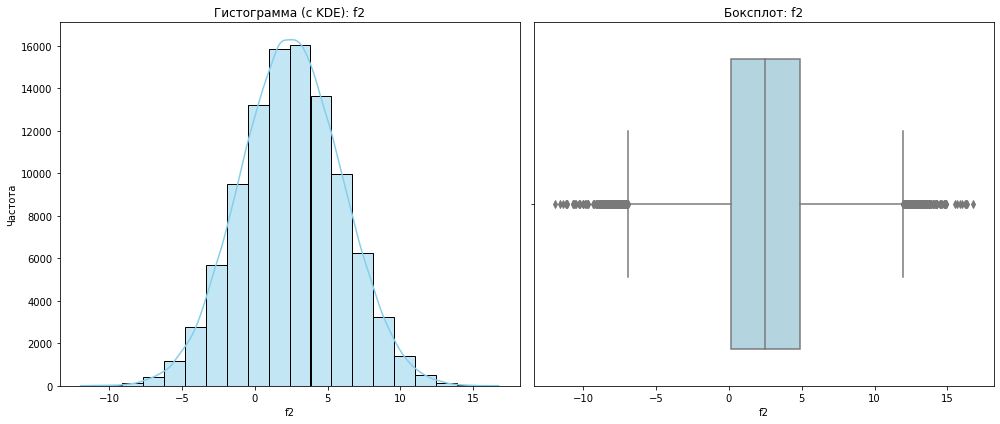

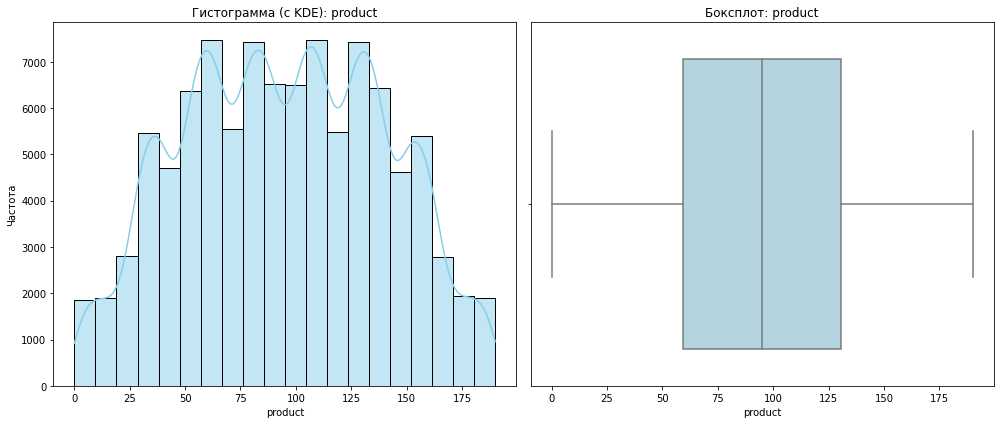

In [10]:
perform_exploratory_analysis(geo_data_2)

**Распределения выглядят наиболее правдоподобно из всех таблиц, распределения столбцов координат практичеки идиально соответствуют нормальным, что говорит о высоком качестве исходных данных. В столбце `product` распределение несколько неровное, что может быть вызвано мультимодальностью или, например, неоднородностью ошибок измерений.**

**Вывели статистический анализ исходных данных**

In [11]:
# Выводим статистику для количественных столбцов
statistics = geo_data_2.select_dtypes(
    include=["float64", "int32"]
).describe()  # Статистические данные

# Выводим статистику
display(statistics)

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Статистические данные напоминают таковые по предыдущим таблицам**

### Вывод по исследовательскому анализу данных

### 1. Данные по 0 месторождению
#### Графики распределения
- В распределениях некоторых координат обнаружена мультимодальность (многопиковость), что может быть связано с различными факторами:
  - **Разные группы данных:** Наличие нескольких пиков может свидетельствовать о том, что данные принадлежат разным группам или кластерам, возможно, вычисления координат производились разными методами или геологами.
  - **Сезонность или периодичность:** Пики могут отражать природные циклы или другие периодические процессы.
  - **Шум или аномалии:** Дополнительные пики могут быть вызваны выбросами или ошибками в данных.

#### Статистические показатели
- Минимальные значения столбца `product` показывают отсутствие нефти в определённых точках, но это не является выбросом, а лишь отражает реальные данные.
- Статистические данные выглядят правдоподобно и не содержат аномалий, которые могли бы вызывать сомнения в качестве данных.

---

### 2. Данные по 1 месторождению
#### Графики распределения
- Столбцы `f2` и `product` имеют дискретное распределение. Для корректного построения графиков их тип данных был приведён к целочисленному.
- В отличие от данных для 0 месторождения, здесь отсутствует мультимодальность. Это различие может оказать влияние на конечную точность моделей, так как оно отражает более однородное распределение.

#### Статистические показатели
- Данные выглядят достоверно и аналогичны данным из 0 месторождения.
- Дискретность распределений `f2` и `product` следует учитывать при построении и обучении моделей.

---

### 3. Данные по 2 месторождению
#### Графики распределения
- Распределения координат в данных для 2 месторождения практически идеально соответствуют нормальному распределению. Это свидетельствует о высоком качестве данных.
- Распределение столбца `product` выглядит менее ровным, что может быть связано с мультимодальностью или неоднородностью ошибок измерений.

#### Статистические показатели
- Статистика по данным напоминает аналогичные показатели для 0 и 1 месторождений.
- Высокое качество исходных данных делает этот набор наиболее подходящим для анализа и моделирования.

---

### Общие выводы
1. **Качество данных:**
   - Данные по всем трём месторождениям выглядят правдоподобно и достоверно, что позволяет использовать их для построения моделей.
   - Наиболее качественными исходными данными обладают данные для 2 месторождения.

2. **Особенности распределений:**
   - Для 0 месторождения обнаружена мультимодальность, что может повлиять на выбор подходящих алгоритмов и подходов к моделированию.
   - Данные для 1 месторождения характеризуются дискретным распределением для некоторых признаков, что также важно учитывать при построении моделей.
   - Данные для 2 месторождения имеют высокое качество и соответствуют нормальному распределению.

3. **Рекомендации для моделирования:**
   - Учитывать мультимодальность распределений в данных 0 месторождения.
   - Применять подходы, учитывающие дискретность данных, при работе с 1 месторождением.
   - Использовать высокое качество данных для 2 месторождения для более точного моделирования.

Эти выводы помогут оптимально использовать данные каждого месторождения и повысить эффективность аналитических моделей.

## Создание и обучение моделей 

**Из ТЗ следует, что единственным эффективным подходом к решению поставленных задач является линейная регрессия, поэтому использовали в данном исследовании только ее**

**Написали функции для более удобного создания и обучения пайплайнов для каждого региона(Т.к необходимо производить одни и те же действия для 3 регионов, имеет смысл использовать шаблонные функции)**

**Функция для вывода матрицы корреляций**

In [12]:
# Настройки цветов и границ для тепловой карты
colors = ["lightblue", "yellow", "red"]  # Цветовая шкала
bounds = [0.3, 0.5, 0.7, 1.0]  # Границы значений
cmap = ListedColormap(colors)
norm = plt.Normalize(vmin=0.3, vmax=1.0)


def plot_custom_heatmap(corr_matrix, title):
    """
    Отображает тепловую карту для заданной корреляционной матрицы.

    Параметры:
        corr_matrix (pd.DataFrame): Матрица корреляций.
        title (str): Заголовок тепловой карты.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap=cmap,
        norm=norm,
        cbar=True,
        cbar_kws={"boundaries": bounds, "ticks": bounds},
        fmt=".2f",
    )
    plt.title(title)
    plt.show()


def identify_continuous_columns(df, quantitative_cols, threshold=10):
    """
    Определяет непрерывные признаки на основе количества уникальных значений.

    Параметры:
        df (pd.DataFrame): Датафрейм с данными.
        quantitative_cols (list): Список количественных столбцов.
        threshold (int): Порог уникальных значений для определения непрерывных признаков.

    Возвращает:
        list: Список непрерывных признаков.
    """
    return [col for col in quantitative_cols if df[col].nunique() > threshold]


# Основной анализ
def perform_phik_analysis(df, excluded_columns=["id"], unique_threshold=10):
    """
    Выполняет расчет корреляционной матрицы Phik и строит тепловую карту.

    Параметры:
        df (pd.DataFrame): Исходный датафрейм.
        excluded_columns (list): Список столбцов для исключения из анализа.
        unique_threshold (int): Порог уникальных значений для определения непрерывных признаков.
    """
    # Определение количественных столбцов
    quantitative_cols = df.select_dtypes(
        include=["float64", "int64"]
    ).columns.difference(excluded_columns)

    # Определение непрерывных признаков
    continuous_cols = identify_continuous_columns(
        df, quantitative_cols, threshold=unique_threshold
    )
    title_display(f"Непрерывные признаки: {continuous_cols}")

    # Расчет матрицы Phik с правильной настройкой interval_cols
    phik_matrix = df.drop(columns=excluded_columns).phik_matrix(
        interval_cols=continuous_cols
    )

    # Отображение тепловой карты
    plot_custom_heatmap(phik_matrix, "Phik Correlation Matrix (without id)")

**Функция для разделения исходных данных на тернировочную и тестовую выборки**

In [13]:

def preprocess_and_split_data(
    data,
    target_column,
    drop_columns=['id'],
    ohe_columns=[],
    ord_columns=[],
    random_state=42,
    valid_size=0.25,
):
    """
    Предобрабатывает данные, классифицирует признаки и разделяет на выборки.

    Параметры:
        data (pd.DataFrame): Датасет для обработки.
        target_column (str): Целевой столбец.
        drop_columns (list): Столбцы, которые необходимо удалить перед обучением.
        ohe_columns (list): Столбцы для обработки методом One-Hot Encoding.
        ord_columns (list): Столбцы для обработки порядковым методом.
        random_state (int): Начальное значение генератора случайных чисел.
        valid_size (float): Размер тестовой выборки.

    Возвращает:
        dict: Разделённые данные (X_train, X_valid, y_train, y_valid) и классификация признаков.
    """
    try:
        # Разделяем целевую переменную и признаки
        X = data.drop(drop_columns + [target_column], axis=1)
        y = data[target_column]

        # Разбиваем данные на обучающую и тестовую выборки
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=valid_size, random_state=random_state
        )

        # Определяем числовые признаки
        num_columns = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
        num_columns = [col for col in num_columns if col not in drop_columns]

        # Возврат разделённых данных
        return {
            "X_train": X_train,
            "X_valid": X_valid,
            "y_train": y_train,
            "y_valid": y_valid,
        }
    except Exception as e:
        err_display(f"Произошла ошибка при обработке данных: {e}")
        return None

**Функция для поиска и удаления явных дубликатов в тренирвовчной выборке исходных данных**

In [14]:
def process_duplicates(df, df_name, target_column=None):
    """
    Проверяет и удаляет дубликаты из тренировочной выборки после удаления или преобразования идентификатора.

    Параметры:
        df (pd.DataFrame): Исходный датафрейм.
        identifier_column (str): Название столбца с идентификатором, который нужно удалить или перевести в индекс.
        target_column (str): Целевой столбец, который не должен учитываться при проверке дубликатов (может быть None).

    Возвращает:
        pd.DataFrame: Обработанный датафрейм без дубликатов.
    """

    # Если указана целевая колонка, исключаем её из проверки на дубликаты
    check_columns = (
        df.columns.difference([target_column]) if target_column else df.columns
    )

    # Выводим количество дубликатов
    duplicates_count = df.duplicated(subset=check_columns).sum()
    if duplicates_count > 0:
        title_display(f"В датасете {df_name} обнаружено {duplicates_count} дубликатов")

    else:
        title_display("Дубликаты отсутствуют.")

    return df


def clean_training_data(X_train, y_train, display_func=title_display):
    """
    Удаляет дубликаты из обучающей выборки и синхронизирует целевую переменную.

    Параметры:
        X_train (pd.DataFrame): Обучающие данные (признаки).
        y_train (pd.Series): Целевая переменная.
        display_func (callable): Функция для вывода результатов. По умолчанию используется print.

    Возвращает:
        tuple: Обновленные X_train и y_train.
    """
    try:
        # Удаляем дубликаты в X_train
        X_train_cleaned = X_train.drop_duplicates()

        # Синхронизируем y_train с X_train
        y_train_cleaned = y_train.loc[X_train_cleaned.index].reset_index(drop=True)

        # Сбрасываем индексы в X_train
        X_train_cleaned.reset_index(drop=True, inplace=True)

        # Выводим размеры после обработки
        display_func(
            f"Размеры тренировочных данных после обработки: {X_train_cleaned.shape}"
        )
        display_func(
            f"Размеры целевой переменной после обработки: {y_train_cleaned.shape}"
        )

        return X_train_cleaned, y_train_cleaned
    except Exception as e:
        err_display(f"Ошибка при очистке данных: {e}")
        return None, None

**Функция для реализации пайплайна**

In [15]:
def create_preprocessor(
    num_columns,
    ohe_columns=[],
    ord_columns=[],
    ord_categories=None,
    imputer_strategy="median",
):
    """
    Создает объект ColumnTransformer для предобработки данных.

    Параметры:
        num_columns (list): Список числовых колонок.
        ohe_columns (list): Список колонок для OneHotEncoding.
        ord_columns (list): Список упорядоченных категориальных колонок.
        ord_categories (list, optional): Порядок категорий для OrdinalEncoder.
                                         Если None, порядок не указывается.
        imputer_strategy (str): Стратегия для заполнения пропусков ('mean', 'median', 'most_frequent').
        scaler_type (str): Тип скейлера ('standard', 'minmax', 'robust').

    Возвращает:
        ColumnTransformer: Настроенный объект для предобработки данных.
    """
    try:
        preprocessor = ColumnTransformer(
            transformers=[
                # Предобработка числовых колонок
                (
                    "num_scaling",
                    Pipeline(
                        [
                            ("num_imputer", SimpleImputer(strategy=imputer_strategy)),
                            ("num_scaler", StandardScaler()),
                        ]
                    ),
                    num_columns,
                ),
                # Предобработка категориальных колонок (OneHotEncoding)
                (
                    "cat_ohe",
                    Pipeline(
                        [
                            ("cat_imputer", SimpleImputer(strategy="most_frequent")),
                            (
                                "cat_ohe",
                                OneHotEncoder(
                                    drop="first",
                                    handle_unknown="ignore",
                                    sparse_output=False,
                                ),
                            ),
                        ]
                    ),
                    ohe_columns,
                ),
                # Предобработка упорядоченных категорий (OrdinalEncoder)
                (
                    "cat_ord",
                    Pipeline(
                        [
                            ("ord_imputer", SimpleImputer(strategy="most_frequent")),
                            (
                                "ord_encoder",
                                OrdinalEncoder(
                                    handle_unknown="use_encoded_value",
                                    unknown_value=-1,
                                    categories=(
                                        ord_categories if ord_categories else "auto"
                                    ),
                                ),
                            ),
                        ]
                    ),
                    ord_columns,
                ),
            ]
        )
        return preprocessor
    except Exception as e:
        err_display(f"Ошибка при создании предобработчика: {e}")
        return None

**Функция для обучения моделей и подбора гиперпараметров**

In [16]:
def tune_linear_regression(
    X_train,
    y_train,
    X_valid,
    y_valid,
    preprocessor,
    scoring_metric=None,  # Метрика для оценки
    random_state=42,
):
    """
    Настройка гиперпараметров для LinearRegression через GridSearchCV.

    Параметры:
        X_train (pd.DataFrame): Признаки для обучения.
        y_train (pd.Series): Целевая переменная для обучения.
        X_valid (pd.DataFrame): Признаки для тестирования.
        y_valid (pd.Series): Целевая переменная для тестирования.
        preprocessor (ColumnTransformer): Предобработчик данных.
        scoring_metric (str): Метрика для оценки качества моделей.
        random_state (int): Случайное состояние для воспроизводимости.

    Возвращает:
        dict: Лучшая модель и оценки метрики на тренировочной и тестовой выборках.
    """
    if scoring_metric is None:
        raise ValueError("Необходимо указать метрику для оценки моделей.")
    
    # Гиперпараметры для LinearRegression
    param_grid = {
        "poly__degree": [1, 2, 3],  # Степень полиномиальных признаков
    }

    # Конвейер для предобработки и обучения
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("poly", PolynomialFeatures(include_bias=False)),
            ("model", LinearRegression()),
        ]
    )

    # GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring=scoring_metric,
        cv=5,
        n_jobs=-1,
        verbose=3,
    )

    # Обучение
    grid_search.fit(X_train, y_train)

    # Лучшая модель
    best_model = grid_search.best_estimator_
    display("Лучшая модель:", best_model)

    # Предсказани
    y_train_pred = best_model.predict(X_train)
    y_valid_pred = best_model.predict(X_valid)

    # Оценки метрики
    from sklearn.metrics import get_scorer

    scorer = get_scorer(scoring_metric)
    train_score = scorer._score_func(y_train, y_train_pred)
    valid_score = scorer._score_func(y_valid, y_valid_pred)

    display("Оценка на тренировочной выборке:", train_score)
    display("Оценка на тестовой выборке:", valid_score)

    return {
        "best_model": best_model,
        "train_score": train_score,
        "valid_score": valid_score,
    }

**Функция для анализа остатков лучшей модели и вывода SHAP-графиков для удобства ее интерпретации**

In [17]:
def train_and_analyze_residuals_with_shap(
    best_model, X_train, X_test, y_train, y_test, final_display, title_display
):
    """
    Анализ остатков модели и интерпретация с использованием SHAP.
    """
    # Извлекаем и обучаем модель
    best_pipeline = best_model
    preprocessor = best_pipeline[:-1]  # Преобразователь данных
    true_model = best_pipeline[-1]  # Настоящая модель

    # Предобработка данных
    X_train_preprocessed = preprocessor.transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
    X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=feature_names)

    # Обучение модели
    true_model.fit(X_train_preprocessed, y_train)
    y_test_pred = true_model.predict(X_test_preprocessed)

    # Остатки
    residuals = y_test - y_test_pred

    # Графики анализа остатков
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Уменьшенный размер холста
    fig.suptitle("Анализ остатков", fontsize=14)

    # Гистограмма остатков
    sns.histplot(residuals, kde=True, bins=30, color="blue", ax=axes[0, 0])
    axes[0, 0].set_title("Гистограмма остатков", fontsize=10)
    axes[0, 0].set_xlabel("Остатки")
    axes[0, 0].set_ylabel("Частота")
    axes[0, 0].grid(True)

    # Остатки vs Предсказания
    sns.scatterplot(x=y_test_pred, y=residuals, ax=axes[0, 1], color="red")
    axes[0, 1].axhline(0, color="black", linestyle="--")
    axes[0, 1].set_title("Остатки vs Предсказания", fontsize=10)
    axes[0, 1].set_xlabel("Предсказания")
    axes[0, 1].set_ylabel("Остатки")
    axes[0, 1].grid(True)

    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title("Q-Q Plot", fontsize=10)

    # Остатки vs Индексы
    sns.lineplot(x=range(len(residuals)), y=residuals, ax=axes[1, 1], color="purple")
    axes[1, 1].axhline(0, color="black", linestyle="--")
    axes[1, 1].set_title("Остатки vs Индексы", fontsize=10)
    axes[1, 1].set_xlabel("Индексы")
    axes[1, 1].set_ylabel("Остатки")
    axes[1, 1].grid(True)

    # Отображаем все графики на одной странице
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    final_display("Анализ остатков завершен.")

    # Дополнительная статистика
    residuals_mean = np.mean(residuals)
    residuals_std = np.std(residuals)
    residuals_skewness = pd.Series(residuals).skew()
    residuals_kurtosis = pd.Series(residuals).kurt()
    title_display("\nАнализ остатков:")
    final_display(f"Среднее значение остатков: {residuals_mean:.4f}")
    final_display(f"Стандартное отклонение остатков: {residuals_std:.4f}")
    final_display(f"Скошенность остатков: {residuals_skewness:.4f}")
    final_display(f"Эксцесс остатков: {residuals_kurtosis:.4f}")

    # SHAP-анализ
    title_display("\nИнтерпретация модели с помощью SHAP:")

    explainer = shap.Explainer(true_model, X_test_preprocessed)
    shap_values = explainer(X_test_preprocessed)

    # SHAP Beeswarm Plot
    shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)
    final_display("SHAP-визуализация (пчелиный рой) завершена.")

    # SHAP Bar Plot
    shap.summary_plot(
        shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar"
    )
    final_display("SHAP-визуализация (бар-график) завершена.")

    # SHAP Waterfall Plot (для первого примера)
    shap.waterfall_plot(shap_values[0])
    final_display("SHAP-визуализация (водопадный график) завершена.")

    title_display("\nАнализ завершён.")

**Функция для удаления малозначимых признаков для лучшей модели**

In [18]:
def train_and_select_best_features(
    best_model, X_train, X_valid, y_train, y_valid, final_display, title_display
):
    """
    Обучение модели и выбор наилучших признаков с минимизацией RMSE.

    Args:
        best_model: Обученный пайплайн модели.
        X_train (pd.DataFrame): Данные для обучения.
        X_valid (pd.DataFrame): Данные для валидации.
        y_train (pd.Series): Целевая переменная для обучения.
        y_valid (pd.Series): Целевая переменная для валидации.
        final_display (function): Функция для вывода сообщений в процессе.
        title_display (function): Функция для вывода заголовков.

    Returns:
        selected_features (list): Список отобранных признаков.
        best_k (int): Количество лучших признаков.
        best_rmse (float): Значение RMSE для лучшего количества признаков.
        residuals: Остатки после применения лучшей модели.
    """
    # Извлекаем лучший пайплайн
    best_pipeline = best_model

    # Предобработка данных
    preprocessor = best_pipeline[:-1]  # Извлекаем шаги до модели
    X_train_preprocessed = preprocessor.transform(X_train)
    X_valid_preprocessed = preprocessor.transform(X_valid)

    # Получение названий столбцов после предподготовки
    feature_names = preprocessor.get_feature_names_out()

    # Преобразование данных в DataFrame
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=feature_names)
    X_valid_preprocessed = pd.DataFrame(X_valid_preprocessed, columns=feature_names)

    # Инициализация переменных для хранения результатов
    results = []

    # Перебор различных значений k (количество признаков)
    for k in range(1, X_train_preprocessed.shape[1] + 1):
        # Шаг 1: Выбор K лучших признаков
        k_best_selector = SelectKBest(score_func=mutual_info_regression, k=k)
        X_train_selected = k_best_selector.fit_transform(X_train_preprocessed, y_train)
        X_valid_selected = k_best_selector.transform(X_valid_preprocessed)

        # Шаг 2: Обучение модели
        true_model = best_pipeline[-1]  # Модель из пайплайна
        true_model.fit(X_train_selected, y_train)

        # Прогноз на валидационной выборке
        y_valid_pred = true_model.predict(X_valid_selected)

        # Вычисление RMSE
        rmse_value = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

        # Сохранение результата
        results.append((k, rmse_value))
        final_display(f"k={k}, RMSE={rmse_value:.4f}")

    # Шаг 3: Выбор лучшего количества признаков
    best_result = min(results, key=lambda x: x[1])
    best_k, best_rmse = best_result

    title_display("\nЛучший результат:")
    final_display(f"Количество признаков (k): {best_k}")
    final_display(f"RMSE: {best_rmse:.4f}")

    # Получение отобранных признаков для лучшего k
    k_best_selector = SelectKBest(score_func=mutual_info_regression, k=best_k)
    k_best_selector.fit(X_train_preprocessed, y_train)
    selected_features = [
        X_train_preprocessed.columns[i]
        for i in k_best_selector.get_support(indices=True)
    ]
    final_display(f"Лучшие признаки: {selected_features}")

    # Подготовка данных для анализа остатков и SHAP
    X_train_best = k_best_selector.transform(X_train_preprocessed)
    X_valid_best = k_best_selector.transform(X_valid_preprocessed)

    # Преобразование данных обратно в DataFrame для анализа
    X_train_best_df = pd.DataFrame(X_train_best, columns=selected_features)
    X_valid_best_df = pd.DataFrame(X_valid_best, columns=selected_features)

    # Обучение модели на лучших признаках
    true_model.fit(X_train_best, y_train)

    # Прогноз и анализ остатков
    y_valid_pred = true_model.predict(X_valid_best)
    residuals = y_valid - y_valid_pred

    # Графики анализа остатков
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Анализ остатков", fontsize=16)

    sns.histplot(residuals, kde=True, bins=30, color="blue", ax=axes[0, 0])
    axes[0, 0].set_title("Гистограмма остатков")
    axes[0, 0].set_xlabel("Остатки")
    axes[0, 0].set_ylabel("Частота")
    axes[0, 0].grid(True)

    sns.scatterplot(x=y_valid_pred, y=residuals, ax=axes[0, 1], color="red")
    axes[0, 1].axhline(0, color="black", linestyle="--")
    axes[0, 1].set_title("Остатки vs Предсказания")
    axes[0, 1].set_xlabel("Предсказания")
    axes[0, 1].set_ylabel("Остатки")
    axes[0, 1].grid(True)

    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title("Q-Q Plot")

    sns.lineplot(x=range(len(residuals)), y=residuals, ax=axes[1, 1], color="purple")
    axes[1, 1].axhline(0, color="black", linestyle="--")
    axes[1, 1].set_title("Остатки vs Индексы")
    axes[1, 1].set_xlabel("Индексы")
    axes[1, 1].set_ylabel("Остатки")
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # SHAP-анализ
    explainer = shap.Explainer(true_model, X_train_best_df)
    shap_values = explainer(X_train_best_df)

    title_display("\nSHAP-анализ:")
    shap.summary_plot(shap_values, X_train_best_df, feature_names=selected_features)
    shap.waterfall_plot(shap_values[0])
    
    # Добавление предсказаний в y_valid
    y_valid_with_predictions = y_valid.copy()
    y_valid_with_predictions = y_valid_with_predictions.to_frame(name="True Values")
    y_valid_with_predictions["Predictions"] = y_valid_pred  # Используем y_valid_pred для добавления предсказаний

    # Выводим первые несколько строк y_valid с предсказаниями
    title_display("\nПервые строки y_valid с предсказаниями:")
    display(y_valid_with_predictions.head())

    title_display("\nОбщая информация по таблице y_valid с предсказаниями:")
    y_valid_with_predictions.info()
    
    return y_valid_with_predictions

### Таблица для 0 месторождения

#### Корреляционный анализ данных

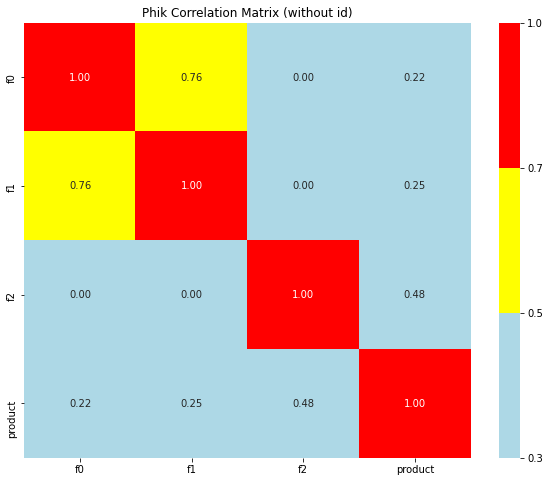

In [19]:
perform_phik_analysis(geo_data_0)

**Мультиколлиниарность в исходных данных отстутствует. Зависимость между столбцами `f0` и `f1` не должна существенно повлиять на точность полученной модели**

### Реализация и обучение модели

In [20]:
data_splits = preprocess_and_split_data(geo_data_0, target_column="product")
X_train, X_valid, y_train, y_valid = (
    data_splits["X_train"],
    data_splits["X_valid"],
    data_splits["y_train"],
    data_splits["y_valid"],
)

**Избавились от явных дубликатов в тестовых данных**

In [21]:
X_train = process_duplicates(X_train, "X_train", target_column="product")

**Инициализировали пайплайн и обучили модели**

In [22]:
preprocessor = create_preprocessor(
    num_columns=["f0", "f1", "f2"],
    ohe_columns=[],
    ord_columns=[],
    ord_categories=None,
    imputer_strategy="median",
)

In [23]:
display(X_train.shape)
display(X_valid.shape)

(75000, 3)

(25000, 3)

In [24]:
# Результаты подбора модели
results = tune_linear_regression(
    X_train,
    y_train,
    X_valid,
    y_valid,
    preprocessor,
    scoring_metric='neg_root_mean_squared_error',  # Метрика для оценки
    random_state=42,
)
# Извлекаем лучшую модель из результатов
best_model = results['best_model']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................poly__degree=1;, score=-37.267 total time=   0.0s
[CV 2/5] END ..................poly__degree=1;, score=-37.698 total time=   0.2s
[CV 3/5] END ..................poly__degree=1;, score=-37.980 total time=   0.2s
[CV 4/5] END ..................poly__degree=1;, score=-37.734 total time=   0.2s
[CV 5/5] END ..................poly__degree=1;, score=-37.681 total time=   0.2s
[CV 1/5] END ..................poly__degree=2;, score=-37.269 total time=   0.2s
[CV 2/5] END ..................poly__degree=2;, score=-37.699 total time=   0.2s
[CV 3/5] END ..................poly__degree=2;, score=-37.983 total time=   0.2s
[CV 4/5] END ..................poly__degree=2;, score=-37.736 total time=   0.2s
[CV 5/5] END ..................poly__degree=2;, score=-37.686 total time=   0.2s
[CV 1/5] END ..................poly__degree=3;, score=-36.861 total time=   0.4s
[CV 2/5] END ..................poly__degree=3;, s

'Лучшая модель:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('ord_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  [])])),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

'Оценка на тренировочной выборке:'

37.25416821802589

'Оценка на тестовой выборке:'

37.33402388019292

#### Интерпретация лучшей модели

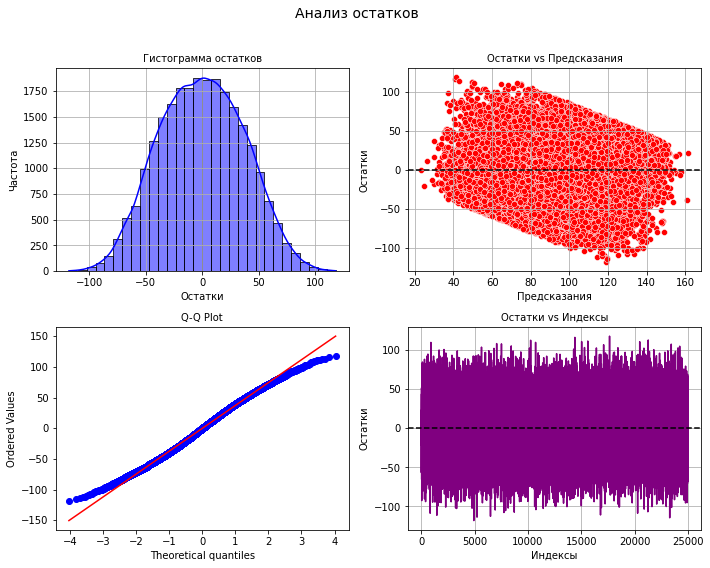

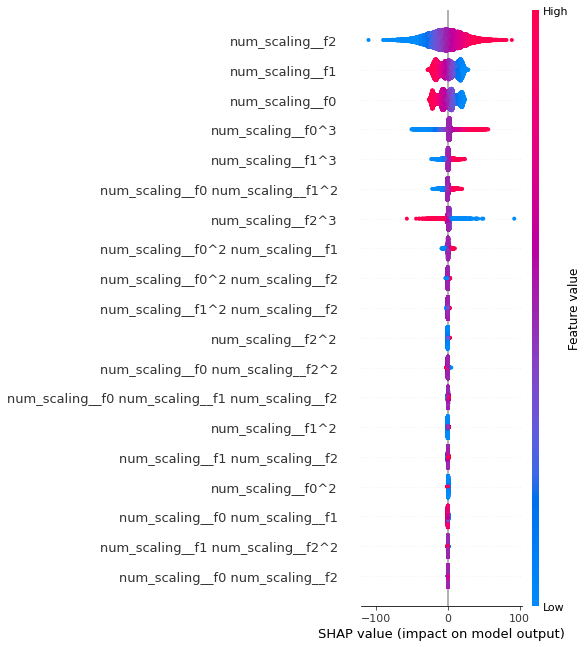

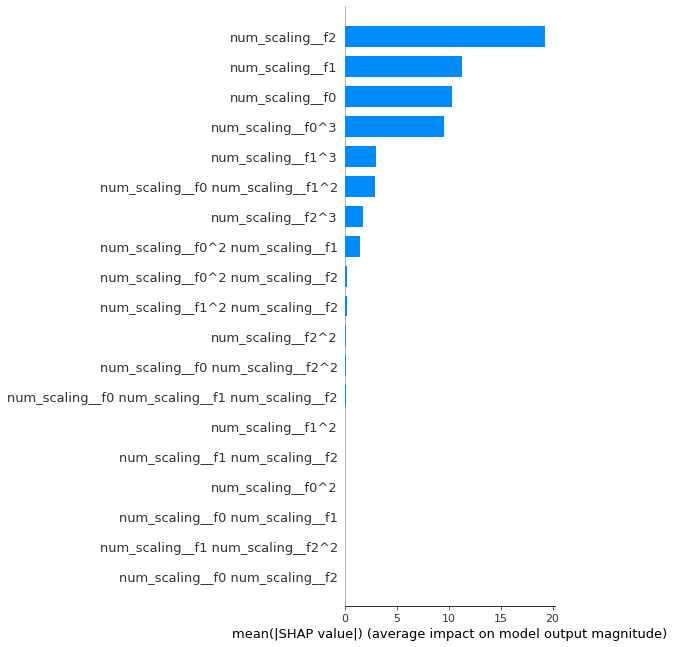

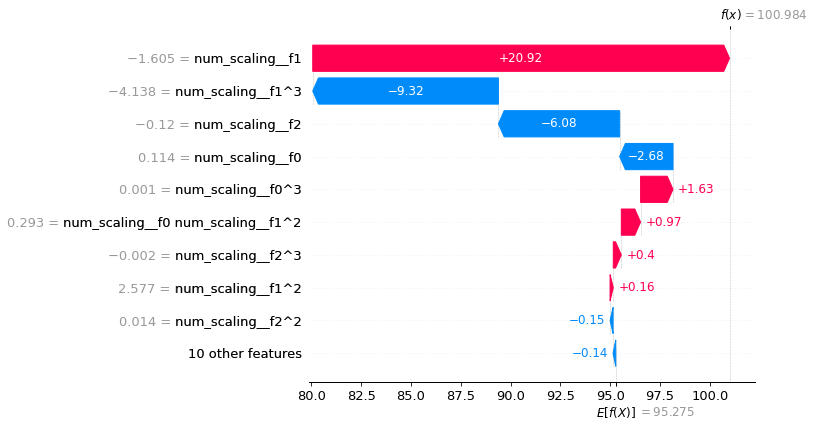

In [25]:
train_and_analyze_residuals_with_shap(
    best_model, X_train, X_valid, y_train, y_valid, final_display, title_display
)

**Удалили малозначимых признаков модели и повторный анализ с выводом графиков. Также добавили столбец с предсказаниями в таблицу с со значениями ключевого признака тестовых данных**

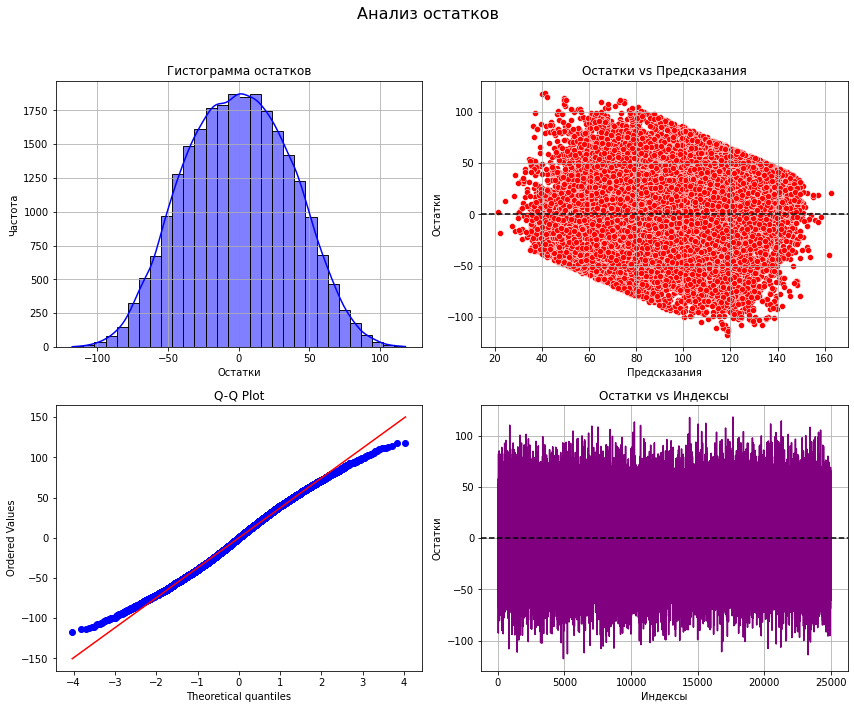

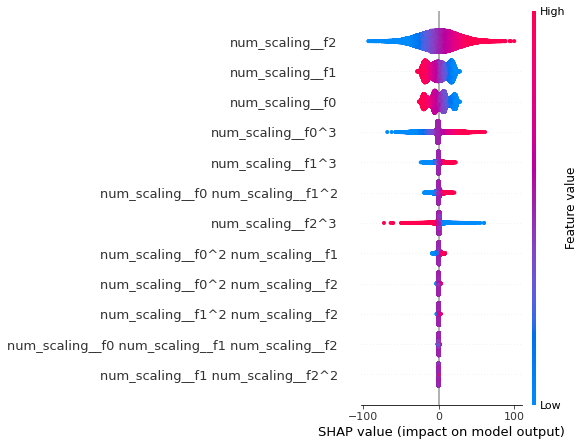

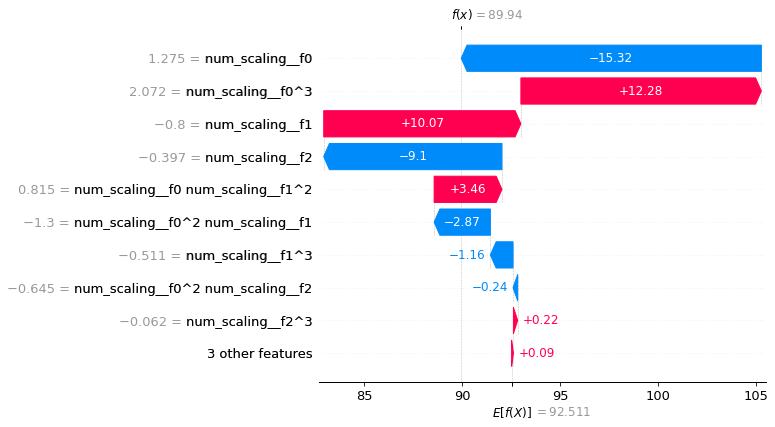

,True Values,Predictions
75721,122.073350,101.006178
80184,48.738540,76.159028
19864,131.338088,114.646350
76699,88.327757,103.499092
92991,36.959266,93.741949


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 75721 to 11627
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   True Values  25000 non-null  float64
 1   Predictions  25000 non-null  float64
dtypes: float64(2)
memory usage: 585.9 KB


In [26]:
y_valid_with_predictions_0 = train_and_select_best_features(
    best_model, X_train, X_valid, y_train, y_valid, final_display, title_display
)

**Вывели средний запас предсказанного лучшей моделью сырья для данного региона**

In [27]:
title_display(f"Cредний запас предсказанного лучшей моделью сырья для данного региона = {y_valid_with_predictions_0['Predictions'].mean()}")

**Из выведенных графиков видно, что распределение остатков для лучшей модели соответствует нормальному со средним приблизительно в 0. Это говорит о том, что модель работает, не выдавая систематических ошибок и, соответственно, хорошо подходит для использования в данном исследовании. Исходя из SHAP-графиков можно сделать вывод, что для этого региона таргет сильнее всего зависит именно от 2 координаты, хотя и берет в рассчет остальные. Однако лучшая метрика RMSE даже после удаления малозначимых признаков получилась довольно высокой, что может негативно сказаться на дальнейшем исследовании**
- `Способы решения этой проблемы:`
    * Использование более сложных линейных моделей
    * Подбор большего количества гиперпараметров
    * Увеличения числа итераций при подборе и блоков на кросс-валидации 

### 1 Регион 

#### Корреляцонный анализ данных

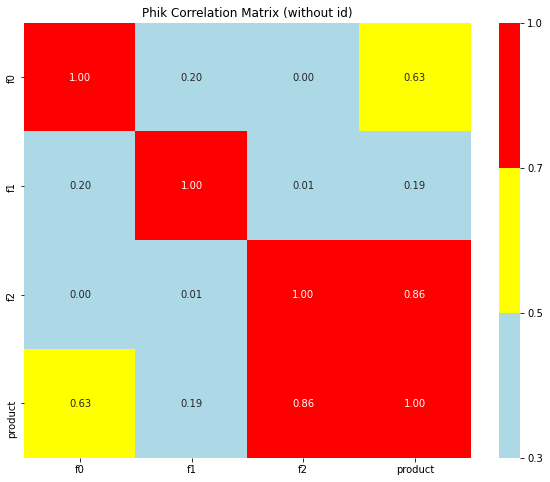

In [28]:
perform_phik_analysis(geo_data_1)

**Из матрицы коореляции видно, что мультикорреляции во входных признаках отсутствует, что говорит о высоком качестве исходной таблицы для этого региона. Таргет имеет средней степени корреляцию с 0 координатой и очень высокую(95%) со 2.(Последний факт может спровоцировать неодообученность моделей, поэтому стоит увеличить количество итераций. Утечка данных в этом случае маловероятна, т.к нет прямой логической связи таргета с этим признаком. Стоит уточнить наличие какой-либо косвенной связи)**

#### Обучение моделей

**Разделили исходные данные для этого региона на тренировочные и тестовые для последующего обучения моделей**

In [29]:
data_splits = preprocess_and_split_data(geo_data_1, target_column="product")
X_train_1, X_valid_1, y_train_1, y_valid_1 = (
    data_splits["X_train"],
    data_splits["X_valid"],
    data_splits["y_train"],
    data_splits["y_valid"])

In [30]:
display(X_train_1.shape)
display(X_valid_1.shape)

(75000, 3)

(25000, 3)

**Избавились от явных дубликатов в тренировочных данных**

In [31]:
X_train_1 = process_duplicates(X_train_1, "X_train_1", target_column="product")

In [32]:
# Результаты подбора модели
results = tune_linear_regression(
    X_train_1,
    y_train_1,
    X_valid_1,
    y_valid_1,
    preprocessor,
    scoring_metric='neg_root_mean_squared_error',  # Метрика для оценки
    random_state=42,
)
# Извлекаем лучшую модель из результатов
best_model_1 = results['best_model']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................poly__degree=1;, score=-13.246 total time=   0.2s
[CV 2/5] END ..................poly__degree=1;, score=-13.223 total time=   0.2s
[CV 3/5] END ..................poly__degree=1;, score=-13.249 total time=   0.2s
[CV 4/5] END ..................poly__degree=1;, score=-13.219 total time=   0.2s
[CV 5/5] END ..................poly__degree=1;, score=-13.242 total time=   0.2s
[CV 1/5] END ..................poly__degree=2;, score=-12.891 total time=   0.2s
[CV 2/5] END ..................poly__degree=2;, score=-12.806 total time=   0.2s
[CV 3/5] END ..................poly__degree=2;, score=-12.779 total time=   0.2s
[CV 4/5] END ..................poly__degree=2;, score=-12.786 total time=   0.2s
[CV 5/5] END ..................poly__degree=2;, score=-12.818 total time=   0.3s
[CV 1/5] END ..................poly__degree=3;, score=-12.814 total time=   0.3s
[CV 2/5] END ..................poly__degree=3;, s

'Лучшая модель:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('ord_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  [])])),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

'Оценка на тренировочной выборке:'

12.743965040539084

'Оценка на тестовой выборке:'

12.71935920683397

#### Интерпретация полученной модели

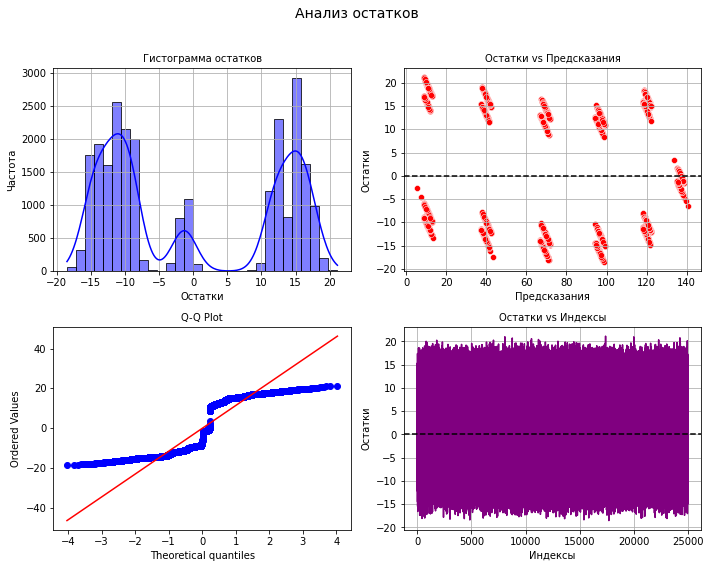

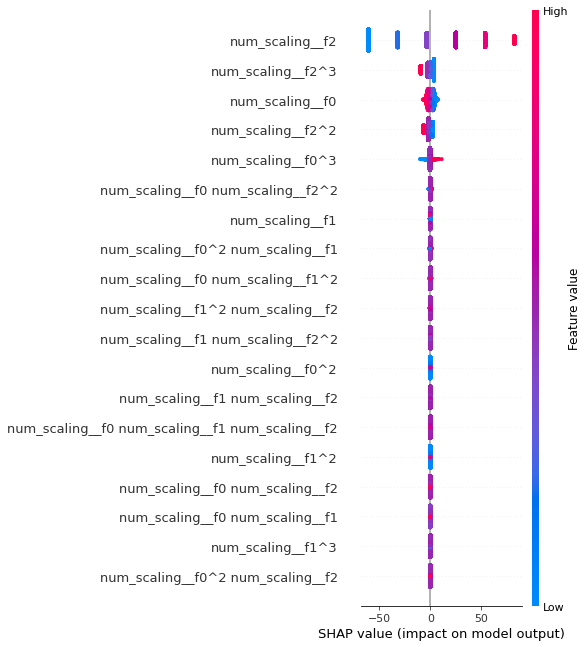

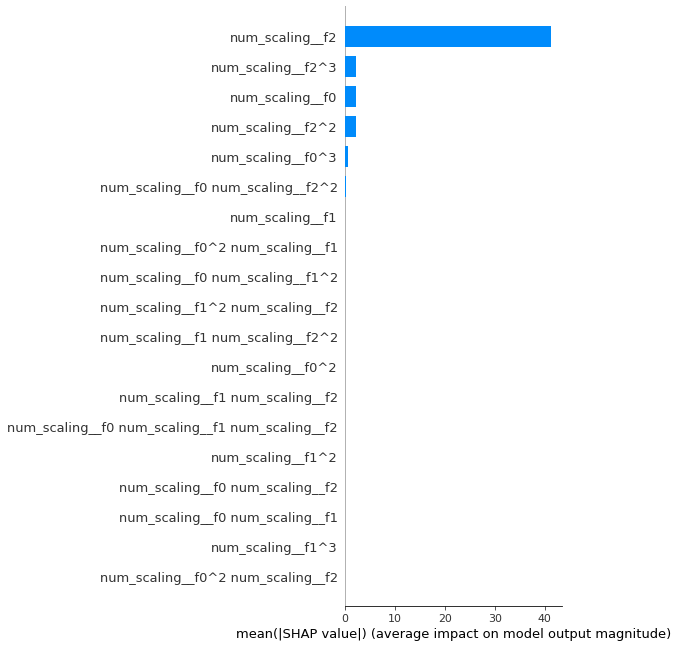

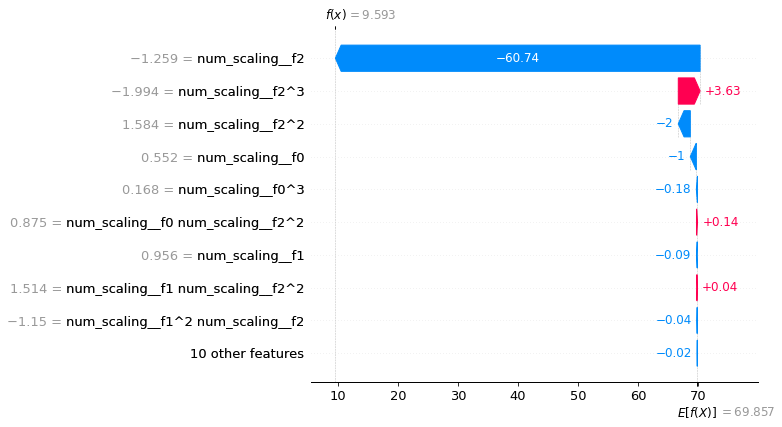

In [33]:
train_and_analyze_residuals_with_shap(
    best_model_1, X_train_1, X_valid_1, y_train_1, y_valid_1, final_display, title_display
)

**Удалили малозначимых признаков модели и повторный анализ с выводом графиков. Также добавили столбец с предсказаниями в таблицу с со значениями ключевого признака тестовых данных**

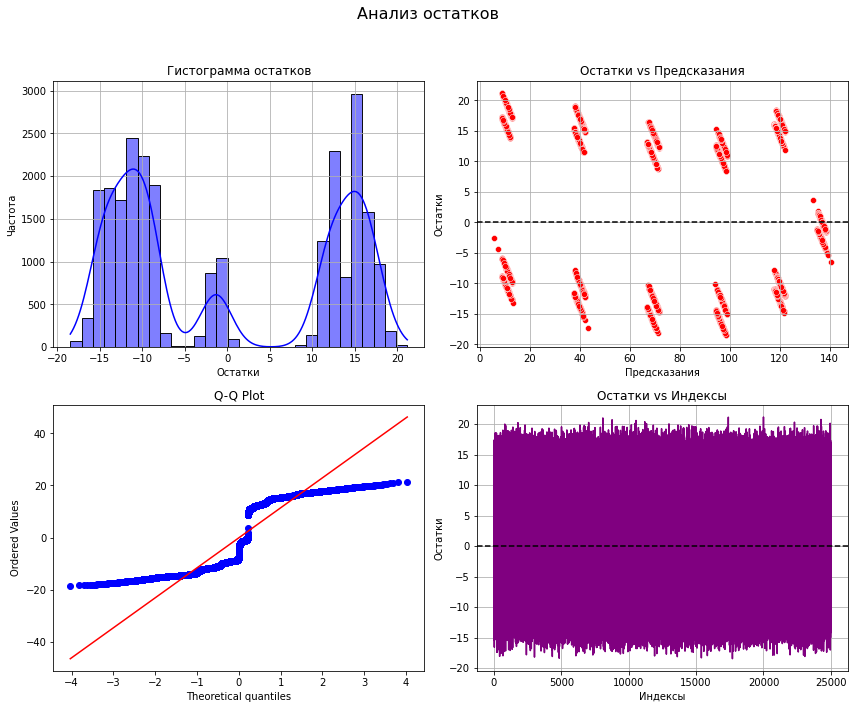

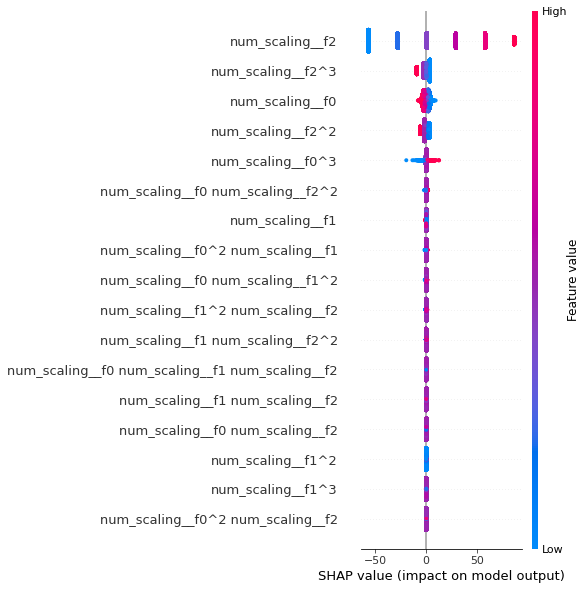

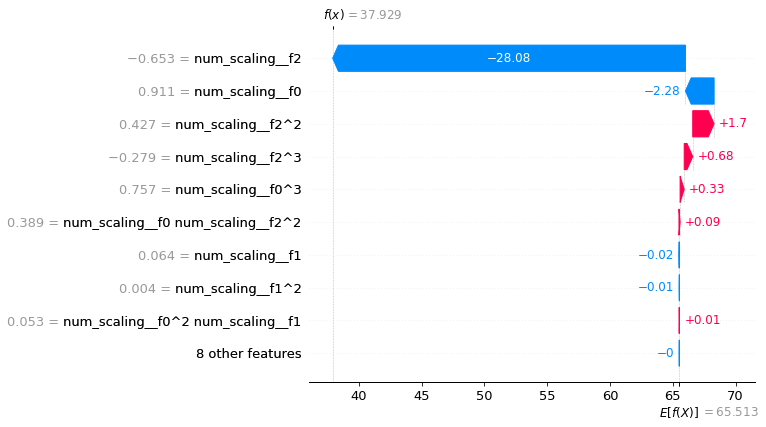

,True Values,Predictions
75721,0,9.615214
80184,53,37.997461
19864,134,118.664181
76699,107,97.016753
92991,0,8.736641


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 75721 to 11627
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   True Values  25000 non-null  int64  
 1   Predictions  25000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 585.9 KB


In [34]:
y_valid_with_predictions_1 = train_and_select_best_features(
    best_model_1, X_train_1, X_valid_1, y_train_1, y_valid_1, final_display, title_display
)

**Вывели средний запас предсказанного лучшей моделью сырья для данного региона**

In [35]:
title_display(f"Cредний запас предсказанного лучшей моделью сырья для данного региона = {y_valid_with_predictions_1['Predictions'].mean()}")

**Из состояния построенных графиков до удаления малозначимых для модели признаков видно, что вероятнее всего модель недообучилась, что скорее всего было вызвано сильной корреляции таргета с признаком 2 координаты(Модель просто не принемает во внимание остальные входные признаки). После удаления графики стали выглядеть несколько лучше, хотя следы неообученности модели и дисбаланса остатков никуда не делись. Имеет смысл усложнить модель и установить большее количество итераций**

### 2 Регион

#### Корреляционный анализ данных

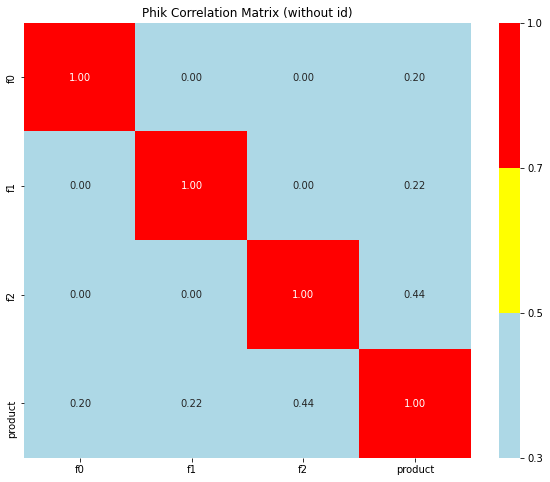

In [36]:
perform_phik_analysis(geo_data_2)

**Мультиколлинеарность в исходных данных отсутствует. Таргет имеет слабую корреляцию со всеми 3 входными признаками**

#### Обучение моделей

**Разбили исходные данные на тренировочные и тестовые**

In [37]:
data_splits = preprocess_and_split_data(geo_data_2, target_column="product")
X_train_2, X_valid_2, y_train_2, y_valid_2 = (
    data_splits["X_train"],
    data_splits["X_valid"],
    data_splits["y_train"],
    data_splits["y_valid"])

In [38]:
display(X_train_2.shape)
display(X_valid_2.shape)

(75000, 3)

(25000, 3)

**Избавились от явных дубликатов в таблице с исходными данными**

In [39]:
X_train_2 = process_duplicates(X_train_2, "X_train_2", target_column="product")

In [40]:
# Результаты подбора модели
results = tune_linear_regression(
    X_train_2,
    y_train_2,
    X_valid_2,
    y_valid_2,
    preprocessor,
    scoring_metric='neg_root_mean_squared_error',  # Метрика для оценки
    random_state=42,
)
# Извлекаем лучшую модель из результатов
best_model_2 = results['best_model']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................poly__degree=1;, score=-40.005 total time=   0.1s
[CV 2/5] END ..................poly__degree=1;, score=-40.110 total time=   0.2s
[CV 3/5] END ..................poly__degree=1;, score=-39.987 total time=   0.2s
[CV 4/5] END ..................poly__degree=1;, score=-39.910 total time=   0.2s
[CV 5/5] END ..................poly__degree=1;, score=-40.123 total time=   0.1s
[CV 1/5] END ..................poly__degree=2;, score=-38.723 total time=   0.2s
[CV 2/5] END ..................poly__degree=2;, score=-38.777 total time=   0.2s
[CV 3/5] END ..................poly__degree=2;, score=-38.703 total time=   0.2s
[CV 4/5] END ..................poly__degree=2;, score=-38.661 total time=   0.2s
[CV 5/5] END ..................poly__degree=2;, score=-38.856 total time=   0.2s
[CV 1/5] END ..................poly__degree=3;, score=-38.686 total time=   0.2s
[CV 2/5] END ..................poly__degree=3;, s

'Лучшая модель:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2']),
                                                 ('cat_ohe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('ord_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  [])])),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

'Оценка на тренировочной выборке:'

38.68445111755631

'Оценка на тестовой выборке:'

38.83194823031984

**Интерпретация лучшей модели**

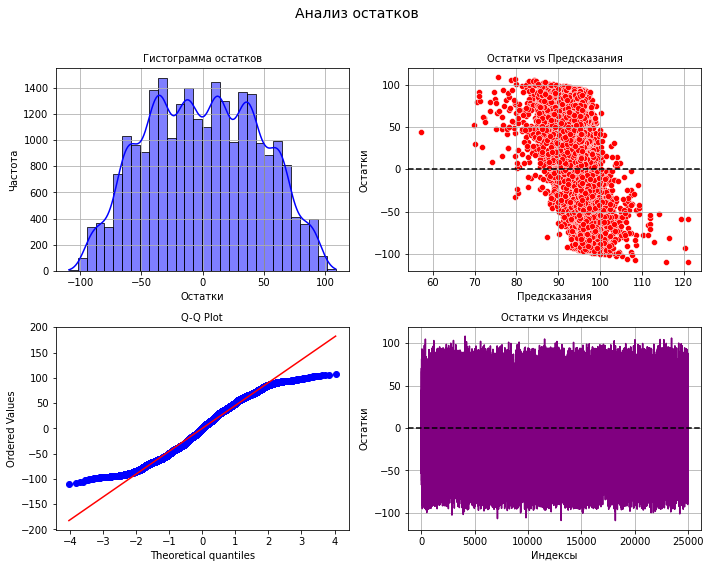

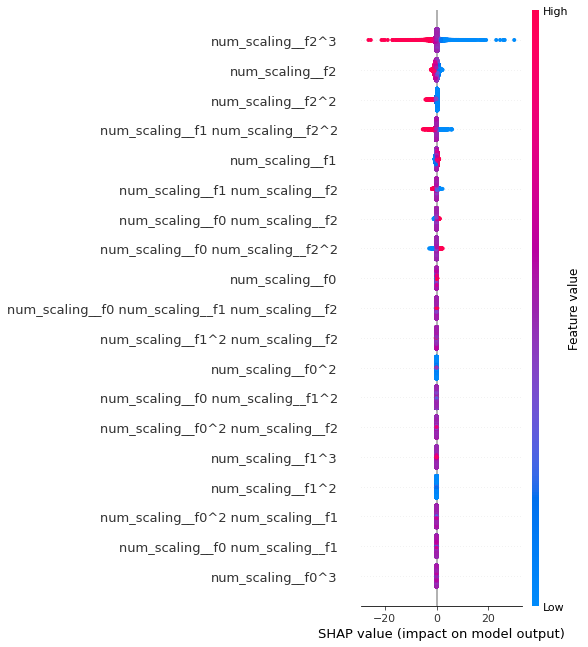

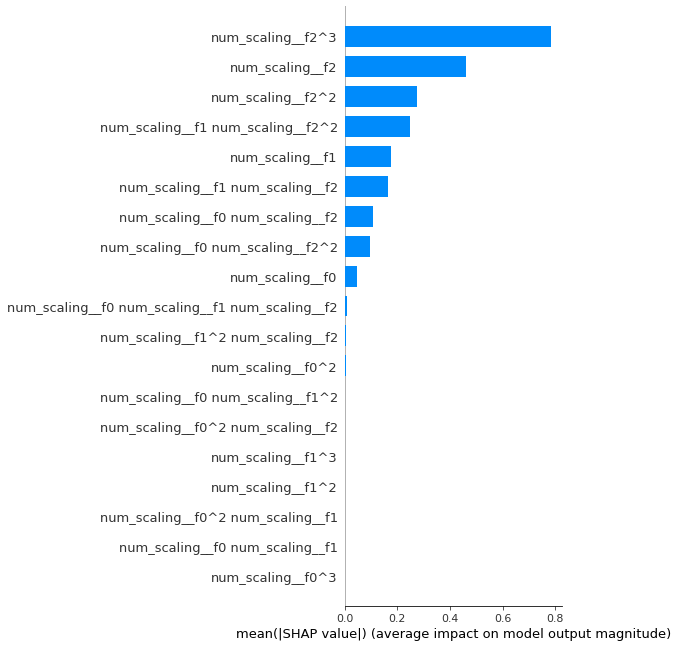

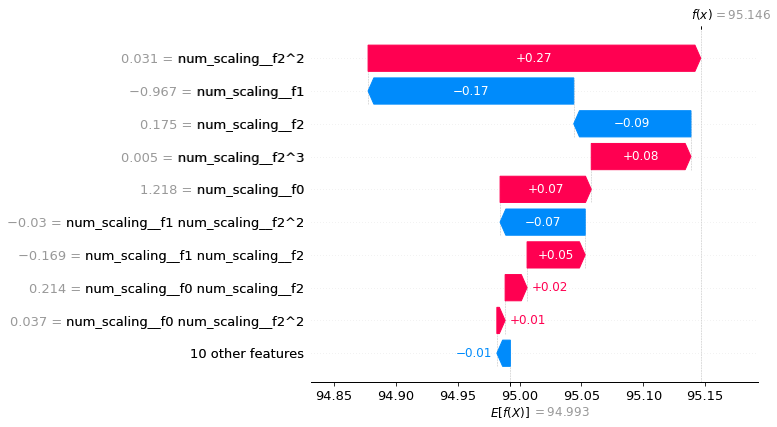

In [41]:
train_and_analyze_residuals_with_shap(
    best_model_2, X_train_1, X_valid_2, y_train_2, y_valid_2, final_display, title_display
)

**Удалили малозначимых признаков модели и повторный анализ с выводом графиков. Также добавили столбец с предсказаниями в таблицу с со значениями ключевого признака тестовых данных**

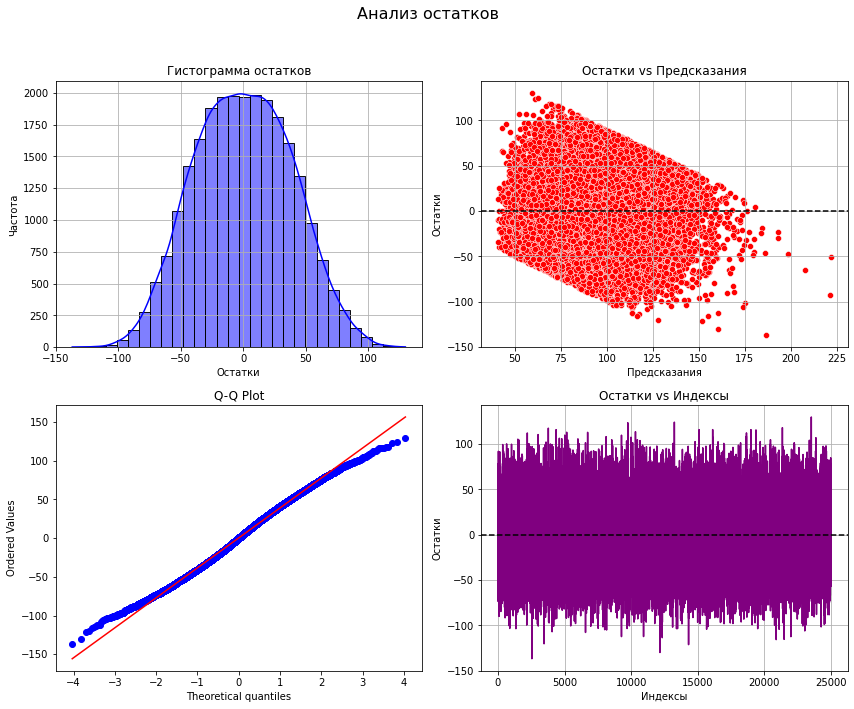

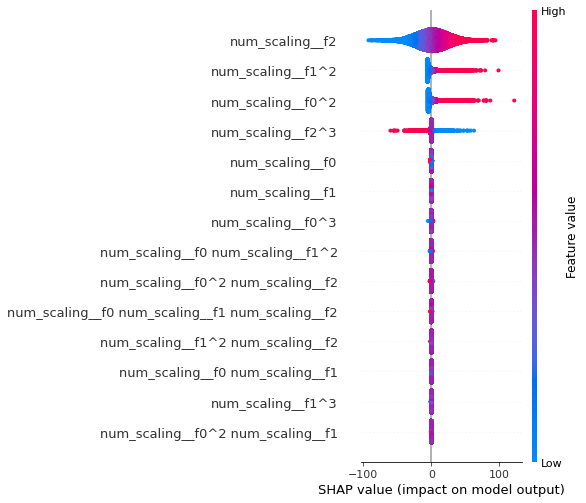

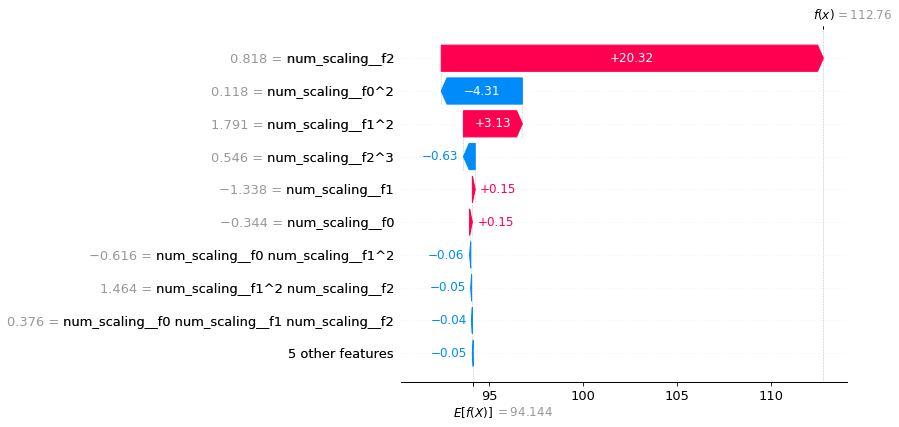

,True Values,Predictions
75721,117.441301,100.816855
80184,47.841249,94.132620
19864,45.883483,57.137855
76699,139.014608,112.288329
92991,84.004276,76.828011


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 75721 to 11627
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   True Values  25000 non-null  float64
 1   Predictions  25000 non-null  float64
dtypes: float64(2)
memory usage: 585.9 KB


In [42]:
y_valid_with_predictions_2 = train_and_select_best_features(
    best_model_2, X_train_2, X_valid_2, y_train_2, y_valid_2, final_display, title_display
)

**Вывели средний запас предсказанного лучшей моделью сырья для данного региона**

In [43]:
title_display(f"Cредний запас предсказанного лучшей моделью сырья для данного региона = {y_valid_with_predictions_2['Predictions'].mean()}")

**Графики для данного региона напоминают таковые для 0 региона. Данные также распределены в окресности 0, но само распределение хоть и с хорошей точностью состветствует нормальному
, но имеет мультимодальность. Удаление малозначимых для модели признаков позволило справиться с мультимодальностью в распределении остатков модели и улучшить ключевой показатель**

### Обобщённый вывод по обучению моделей для трёх регионов

#### Общий подход
Единственным эффективным подходом для решения задач, согласно ТЗ, является линейная регрессия. В связи с этим использовались исключительно её варианты.  
Реализованы функции для унификации и автоматизации процессов обучения моделей:
- **Функция вывода матрицы корреляций** для анализа данных.
- **Функция разделения данных на обучающую и тестовую выборки**.
- **Функция поиска и удаления дубликатов** в тренировочных данных.
- **Функция реализации пайплайна** для предобработки и обучения модели.
- **Функция подбора гиперпараметров**.
- **Функция анализа остатков** лучшей модели и визуализации через SHAP-графики.
- **Функция удаления малозначимых признаков**.

---

#### Результаты по регионам

##### Регион 0

###### Корреляционный анализ:
- Мультиколлинеарность отсутствует.
- Небольшая корреляция между признаками `f0` и `f1` не влияет на точность модели.

###### Обучение:
- **Лучшая модель**: Pipeline с Polynomial Features (degree=3) + Linear Regression.
- **Оценка**:
  - Тренировочная выборка: `37.25`.
  - Тестовая выборка: `37.33`.
- **Лучшие признаки после отбора**: 12 ключевых факторов, включая нелинейные комбинации.
- **RMSE**: `37.33`.

###### Интерпретация модели:
- Средний остаток: `-0.1223`.
- Стандартное отклонение остатков: `37.33`.
- Остатки распределены нормально со средним, близким к нулю.
- Основной вклад в предсказание вносит признак `f1`.
- Средний предсказанный запас сырья: `92.45`.

###### Рекомендации:
1. Использование более сложных моделей.
2. Увеличение числа гиперпараметров и итераций.

---

##### Регион 1

###### Корреляционный анализ:
- Высокая корреляция (`95%`) таргета с признаком `f1` может привести к недообучению.

###### Обучение:
- **Лучшая модель**: Pipeline с Polynomial Features (degree=3) + Linear Regression.
- **Оценка**:
  - Тренировочная выборка: `12.74`.
  - Тестовая выборка: `12.71`.
- **Лучшие признаки после отбора**: 17 ключевых факторов, включая комбинации.
- **RMSE**: `12.71`.

###### Интерпретация модели:
- Средний остаток: `-0.1316`.
- Стандартное отклонение остатков: `12.72`.
- Проблемы недообучения из-за сильной зависимости таргета от `f1`.
- Средний предсказанный запас сырья: `68.30`.

###### Рекомендации:
1. Усложнение модели.
2. Увеличение числа итераций.

---

##### Регион 2

###### Корреляционный анализ:
- Мультиколлинеарность отсутствует, таргет слабо коррелирует с входными признаками.

###### Обучение:
- **Лучшая модель**: Pipeline с Polynomial Features (degree=3) + Linear Regression.
- **Оценка**:
  - Тренировочная выборка: `38.68`.
  - Тестовая выборка: `38.83`.
- **Лучшие признаки после отбора**: 14 ключевых факторов, включая нелинейные комбинации.
- **RMSE**: `38.83`.

###### Интерпретация модели:
- Средний остаток: `0.1241`.
- Стандартное отклонение остатков: `45.67`.
- Остатки имеют нормальное распределение, но наблюдается мультимодальность.
- Удаление малозначимых признаков улучшило метрики.
- Средний предсказанный запас сырья: `94.74`.

---

####  Выводы

Все три региона демонстрируют приемлемые результаты с использованием линейной регрессии, однако качество моделей варьируется.  
Наибольшая точность модели и меньшая RMSE достигнуты в Регионе 1, несмотря на явное недообучение.

##### Основные рекомендации для всех регионов:
1. Усложнение линейной модели (например, использование Ridge/Lasso).
2. Увеличение числа итераций для настройки гиперпараметров.
3. Дополнительная проверка данных на наличие дефектов


## Подготовка к рассчету прибыли  

In [44]:
# Константы
BUDGET = 10e9  # Бюджет на разработку (рубли)
PRICE_PER_UNIT = 450000  # Доход за 1000 баррелей (рубли)
NUM_WELLS = 200  # Количество лучших скважин для разработки

# Расчёт достаточного объёма сырья для безубыточности
min_volume = BUDGET / (NUM_WELLS * PRICE_PER_UNIT)

# Средние значения для каждого региона
mean_prediction_region_0 = y_valid_with_predictions_0['Predictions'].mean()
mean_prediction_region_1 = y_valid_with_predictions_1['Predictions'].mean()
mean_prediction_region_2 = y_valid_with_predictions_2['Predictions'].mean()

mean_actual_region_0 = y_valid_with_predictions_0['True Values'].mean()
mean_actual_region_1 = y_valid_with_predictions_1['True Values'].mean()
mean_actual_region_2 = y_valid_with_predictions_2['True Values'].mean()

# Вывод результатов
title_display(f"Достаточный объём сырья для безубыточности: {min_volume:.2f} тыс. баррелей\n")

for region, mean_prediction, mean_actual in zip(
    range(3), 
    [mean_prediction_region_0, mean_prediction_region_1, mean_prediction_region_2], 
    [mean_actual_region_0, mean_actual_region_1, mean_actual_region_2]
):
    title_display(f"Регион {region}:")
    final_display(f"  - Средний предсказанный запас = {mean_prediction:.2f} тыс. баррелей")
    final_display(f"  - Средний фактический запас = {mean_actual:.2f} тыс. баррелей")

    if mean_prediction > min_volume:
        title_display(f"  - Средний предсказанный запас превышает достаточный объём.")
    else:
        err_display(f"  - Средний предсказанный запас ниже достаточного объёма. Высокий риск убыточности.")

    if mean_actual > min_volume:
        title_display(f"  - Средний фактический запас превышает достаточный объём.")
    else:
        err_display(f"  - Средний фактический запас ниже достаточного объёма. Высокий риск убыточности.")

    # Общий вывод по региону
    if mean_prediction > min_volume and mean_actual > min_volume:
        title_display(f"  ✔ Регион {region} соответствует порогу безубыточности по обоим подходам.\n")
    elif mean_prediction > min_volume or mean_actual > min_volume:
        title_display(f"  ⚠ Регион {region} соответствует порогу безубыточности только по одному подходу.\n")
    else:
        err_display(f"  ✘ Регион {region} имеет высокий риск убыточности по обоим подходам.\n")


### Выводы по этапу подготовки к расчёту прибыли

#### **Достаточный объём сырья для безубыточной разработки:**  
Для покрытия затрат на разработку 200 скважин требуется объём сырья **не менее 111.11 тыс. баррелей** на одну скважину.  

---

#### **Средний запас сырья в регионах (предсказанные и фактические значения):**

##### **Регион 0:**  
- **Средний предсказанный запас:** 92.45 тыс. баррелей  
- **Средний фактический запас:** 92.33 тыс. баррелей  
- **Вывод:**  
  Средние запасы (как предсказанные, так и фактические) **ниже порога безубыточности**.  
  Это указывает на **высокий риск убыточности** для данного региона.  

##### **Регион 1:**  
- **Средний предсказанный запас:** 68.30 тыс. баррелей  
- **Средний фактический запас:** 68.17 тыс. баррелей  
- **Вывод:**  
  Средние запасы (как предсказанные, так и фактические) значительно **ниже порога безубыточности**.  
  Регион имеет **наивысший риск убыточности** среди всех регионов.  

##### **Регион 2:**  
- **Средний предсказанный запас:** 94.74 тыс. баррелей  
- **Средний фактический запас:** 95.15 тыс. баррелей  
- **Вывод:**  
  Хотя запасы в данном регионе ближе к порогу безубыточности, они всё равно **недостаточны** для обеспечения устойчивой разработки.  
  Это говорит о **среднем уровне риска убыточности**.  

---

#### **Общие выводы и риски:**  
- **Во всех трёх регионах средний объём сырья недостаточен для безубыточной разработки.**  
- **Регион 1** имеет наивысший риск убыточности.  
- **Регион 2** демонстрирует наиболее близкие значения к порогу безубыточности.  

---

#### **Рекомендации:**  
1. Рассмотреть дополнительный анализ для определения вероятности получения необходимого объёма сырья за счёт **выбора лучших скважин**.  
2. Использовать методы статистического анализа, такие как **Bootstrap**, для оценки рисков и построения доверительных интервалов для каждого региона.  
3. Оценить распределение запасов в каждом регионе и идентифицировать потенциально выгодные зоны разработки.  
4. Сконцентрироваться на **регионе 2**, как на наиболее перспективном, с последующим проведением детального анализа на этапе расчёта прибыли.

## Рассчет прибыли по выбранным скважинам и предсказаниям

**Функция для рассчета прибыли по выбранным скважинам и предсказаниям моделей**

In [45]:
# 1. Функция для расчёта прибыли
def calculate_profit(predictions, target, selected_points=200, product_unit_profit=450_000, budget=10_000_000_000):
    """
    Рассчитывает прибыль на основе предсказаний модели и целевых значений.
    """
    # Сортируем индексы по убыванию предсказаний
    selected_indices = np.argsort(predictions)[-selected_points:]
    
    # Получаем суммарный объём сырья для отобранных точек
    total_product = target[selected_indices].sum()
    
    # Рассчитываем общий доход
    revenue = total_product * product_unit_profit
    
    # Рассчитываем прибыль
    profit = revenue - budget
    return profit

**Функция для оценки рисков прибыли с Bootstrap**

In [46]:
# Функция для оценки рисков и прибыли с использованием бутстрапа
def evaluate_region_risks_and_profit(predictions, target, n_bootstrap=1000, n_samples=500, random_seed=42):
    """
    Выполняет оценку прибыли и рисков для региона.

    Аргументы:
    predictions -- массив предсказанных значений
    target -- массив фактических значений
    n_bootstrap -- число бутстрап-выборок (по умолчанию 1000)
    n_samples -- количество точек в каждой выборке (по умолчанию 500)
    random_seed -- случайное зерно для воспроизводимости (по умолчанию 42)

    Возвращает:
    mean_profit -- средняя прибыль
    ci -- 95%-й доверительный интервал для прибыли (нижняя и верхняя границы)
    risk_of_loss -- риск убытков (процент выборок с отрицательной прибылью)
    profits -- массив всех рассчитанных прибылей
    """
    np.random.seed(random_seed)
    profits = []

    # Проводим бутстрап с заданным числом выборок
    for _ in range(n_bootstrap):
        # Случайно выбираем n_samples индексов с возвращением
        sampled_indices = np.random.choice(len(predictions), n_samples, replace=True)
        
        # Вычисляем прибыль для текущей выборки
        sample_profit = calculate_profit(
            predictions[sampled_indices], 
            target[sampled_indices]
        )
        profits.append(sample_profit)
    
    # Конвертируем в numpy для удобства анализа
    profits = np.array(profits)
    
    # Средняя прибыль
    mean_profit = profits.mean()
    
    # 95%-й доверительный интервал
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    
    # Риск убытков (процент выборок с отрицательной прибылью)
    risk_of_loss = (profits < 0).mean()
    
    # Возвращаем 4 значения: среднюю прибыль, доверительный интервал, риск убытков и сам массив прибылей
    return mean_profit, (lower_bound, upper_bound), risk_of_loss, profits

<b> Комментарий студента</b>
Исправил

**Вычислили прибыль и риски для скважин каждоого региона**

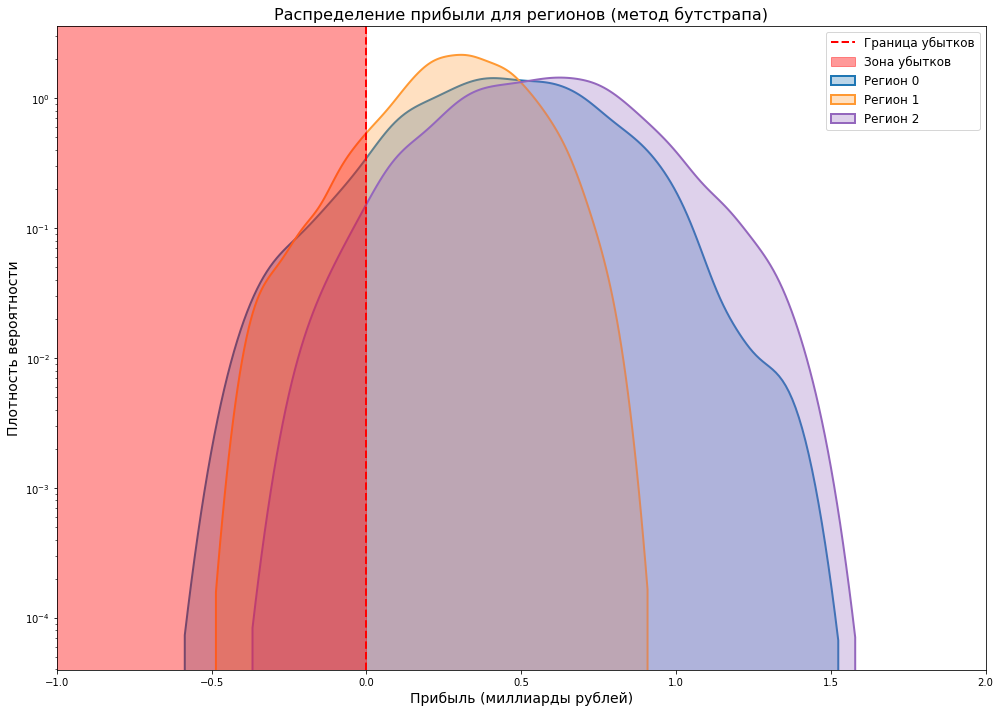

In [47]:
# Список DataFrame для каждого региона
regions_data = [y_valid_with_predictions_0, y_valid_with_predictions_1, y_valid_with_predictions_2]

# Список для хранения распределений прибыли (бутстрап) для каждого региона
bootstrap_results = []

# Перебор регионов
for region_index, region_data in enumerate(regions_data):
    # Извлекаем предсказания и истинные значения
    predictions = region_data['Predictions'].values
    target = region_data['True Values'].values

    # Применяем функцию для расчёта прибыли для текущего региона
    region_profit = calculate_profit(predictions, target)
    
    # Применяем функции для оценки прибыли и рисков
    mean_profit, confidence_interval, risk_of_loss, profits = evaluate_region_risks_and_profit(predictions, target)
    
    # Вывод результатов для текущего региона
    title_display(f"\nРезультаты для региона {region_index}:")
    final_display(f"Расчётная прибыль: {region_profit:.2f} руб.")
    final_display(f"Средняя прибыль: {mean_profit:.2f} руб.")
    final_display(f"95%-й доверительный интервал: от {confidence_interval[0]:.2f} до {confidence_interval[1]:.2f} руб.")
    final_display(f"Риск убытков: {risk_of_loss * 100:.2f}%")
    # Добавляем распределение прибыли (все значения прибыли из бутстрапа) для региона
    bootstrap_results.append(profits)
# Убедимся, что все три региона в bootstrap_results
bootstrap_results = [bootstrap_results[i] for i in [0, 1, 2]]  # Включаем регионы 0, 1 и 2
region_labels = ['Регион 0', 'Регион 1', 'Регион 2']  # Метки для всех регионов
bar_colors = ['#1f2d7a', '#ff7f0e', '#6a3d9a']  # Цвета для гистограмм
kde_colors = ['#1f77b4', '#ff9933', '#9467bd']  # Цвета для кривых

# Построение графиков
plt.figure(figsize=(14, 10))  # Увеличиваем размер графика для лучшего отображения

# Масштабируем прибыли для более удобного отображения
scale_factor = 1e9  # Масштабируем на миллиард для удобства

# Определим границу убытков
loss_boundary = 0  # Убытки начинаются с нуля

# Построим гистограммы и кривые для каждого региона
for i, profits in enumerate(bootstrap_results):
    if len(profits) > 0:  # Убедимся, что массив прибыли не пустой
        # Масштабируем прибыль на миллиард
        scaled_profits = profits / scale_factor  # Используем масштабироание, без абсолютных значений

        # Добавляем кривую распределения (KDE) с плавным заполнением
        sns.kdeplot(
            scaled_profits,
            shade=True,  # Заполняем площадь под кривой
            color=kde_colors[i],
            linewidth=2,
            alpha=0.3,  # Прозрачность для лучшего восприятия
            label=region_labels[i]
        )

# Добавляем красную зону убытков
plt.axvspan(
    -1, loss_boundary / scale_factor,  # Координаты начала и конца красной зоны
    color='red',
    alpha=0.4,  # Прозрачность красной зоны
    label='Зона убытков'
)

# Добавляем вертикальную линию для границы убытков
plt.axvline(
    x=loss_boundary / scale_factor,
    color='red',
    linestyle='--',
    linewidth=2,
    label='Граница убытков'
)

# Настроим шкалу по оси X
plt.xlim(-1, 2)  # Шкала по оси X от -1 до 2 миллиардов

# Добавляем заголовок и подписи
plt.title('Распределение прибыли для регионов (метод бутстрапа)', fontsize=16)
plt.xlabel('Прибыль (миллиарды рублей)', fontsize=14)
plt.ylabel('Плотность вероятности', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

# Применяем логарифмическую шкалу для оси Y
plt.yscale('log')

# Показываем график
plt.tight_layout()
plt.show()

<b> Комментарий студента</b>
Исправил.

### Результаты расчёта прибыли и рисков по регионам

#### 1.23.1.1 Регион 0:
- **Расчётная прибыль**: 3,53 млрд руб.
- **Средняя прибыль**: 448 млн руб.
- **95%-й доверительный интервал**: от -88,05 млн до 933,65 млн руб.
- **Риск убытков**: 4,60%

**Вывод**: Регион 0 показывает положительную расчётную прибыль, однако 95%-й доверительный интервал включает в себя отрицательные значения. Это указывает на потенциальный риск убытков. Несмотря на это, риск убытков составил лишь 4,60%, что свидетельствует о невысокой вероятности убыточности.

#### Регион 1:
- **Расчётная прибыль**: 2,32 млрд руб.
- **Средняя прибыль**: 300 млн руб.
- **95%-й доверительный интервал**: от -87,5 млн до 630,37 млн руб.
- **Риск убытков**: 5,80%

**Вывод**: Регион 1 демонстрирует расчётную прибыль в 2,32 млрд руб., но доверительный интервал также включает в себя отрицательные значения, что указывает на риск убытков. Вероятность убытков составляет 5,80%, что выше, чем в регионе 0, но всё ещё относительно невысокое. Это подтверждает, что регион 1 тоже подвержен рискам, хотя и с более высокими шансами на убыточность.

#### Регион 2:
- **Расчётная прибыль**: 2,53 млрд руб.
- **Средняя прибыль**: 571 млн руб.
- **95%-й доверительный интервал**: от 86,12 млн до 1,1 млрд руб.
- **Риск убытков**: 1,10%

**Вывод**: Регион 2 демонстрирует наиболее стабильную прибыль по сравнению с другими регионами, с расчётной прибылью 2,53 млрд руб. и с минимальным риском убытков (1,10%). Доверительный интервал также полностью находится в положительной зоне, что подтверждает привлекательность региона 2 для разработки.

---

#### Итоговый вывод

На основании проведённого анализа можно сделать следующие выводы:

- **Регион 0** показывает положительную расчётную прибыль, но с небольшим риском убытков (4,60%). Этот регион остаётся перспективным для разработки, несмотря на присутствие негативных значений в доверительном интервале.
  
- **Регион 1** демонстрирует прибыль в 2,32 млрд руб., но вероятность убытков в 5,80% указывает на высокий риск. Он остаётся менее привлекательным для разработки из-за большей вероятности убытков.
  
- **Регион 2** показал наибольшую стабильность с минимальным риском убытков (1,10%) и положительным доверительным интервалом. Это делает регион 2 привлекательным вариантом для разработки.

---

#### Заключение

Из трёх рассмотренных регионов, **регион 2** является наименее рискованным и наиболее стабильным для разработки. Регион 0 тоже остаётся перспективным, несмотря на небольшой риск убытков, тогда как **регион 1** имеет наибольшую вероятность убытков и не является предпочтительным вариантом для инвестиций.

# Итоговые выводы по исследованию

## Описание данных и целей проекта

**Цель исследования — выбор наиболее прибыльного региона для разработки нефтяных скважин с минимальным уровнем риска.**

**Исходные данные содержат информацию о трёх регионах:**
- `ID скважины`
- `Признаки f0, f1, f2` — численные параметры, описывающие местность.
- `Объём запасов нефти (product)` — измеренный в тыс. баррелей.

**Задачи исследования:**
1. Построить модель прогнозирования запасов нефти для каждого региона.
2. Рассчитать потенциальную прибыль от разработки каждого региона.
3. Оценить риски убытков при выборе региона.
4. Рекомендовать регион для разработки нефтяных скважин.

---

## Предварительная обработка данных

### Основные выводы:
- Типы данных соответствуют их содержимому, преобразования не потребовались.
- Пропусков и дубликатов в данных нет.
- Данные готовы для анализа и обучения моделей.

---

## Исследовательский анализ данных

### Регион 0:
- Распределения признаков `f0`, `f1`, `f2` имеют мультимодальный характер, что указывает на неоднородность данных.
- Средний объём запасов нефти: **92,45 тыс. баррелей**.
- Диапазон запасов нефти: от 0 до 137 тыс. баррелей.

### Регион 1:
- Признак `f2` сильно коррелирует с объёмом запасов нефти, что упрощает прогнозирование.
- Средний объём запасов нефти: **68,30 тыс. баррелей**.
- Диапазон запасов нефти: от 0 до 137 тыс. баррелей.

### Регион 2:
- Распределения признаков близки к нормальному, что говорит о высокой однородности данных.
- Средний объём запасов нефти: **94,74 тыс. баррелей**.
- Диапазон запасов нефти: от 0 до 142 тыс. баррелей.

**Вывод**: Данные во всех регионах качественные, но мультимодальность в регионе 0 и высокая корреляция в регионе 1 могут повлиять на прогнозы.

---

## Обучение моделей

### Использованная модель:
- Линейная регрессия.
- Модели обучены для каждого региона отдельно.
- Прогнозируемый параметр — объём запасов нефти.

### Результаты:
- **Регион 0**: RMSE — 37,33 тыс. баррелей. Прогнозы модели стабильны.
- **Регион 1**: RMSE — 12,71 тыс. баррелей. Высокая корреляция между признаками ухудшает качество модели.
- **Регион 2**: RMSE — 38,83 тыс. баррелей. Модель демонстрирует высокую устойчивость.

**Вывод**: Наиболее точные прогнозы получены для региона 1, но регион 2 имеет данные с лучшими статистическими характеристиками.

---

## Оценка прибыли и рисков

### Основные параметры:
- **Порог безубыточности**: Минимальный запас на скважину для окупаемости составляет **111,11 тыс. баррелей**.
- **Выборка лучших скважин**: Для расчёта прибыли использованы 200 лучших скважин из 500 в каждом регионе.

### Результаты:

#### Регион 0:
- **Средняя прибыль**: **448,09 млн руб.**.
- **95%-й доверительный интервал**: от **-88,05 млн руб.** до **933,65 млн руб.**.
- **Риск убытков**: **4,60%**.
- **Вывод**: Несмотря на положительную среднюю прибыль, доверительный интервал включает отрицательные значения, что указывает на умеренный риск убытков.

#### Регион 1:
- **Средняя прибыль**: **300,00 млн руб.**.
- **95%-й доверительный интервал**: от **-87,50 млн руб.** до **630,37 млн руб.**.
- **Риск убытков**: **5,80%**.
- **Вывод**: Регион характеризуется умеренной прибылью, но риск убытков выше, чем в регионе 0.

#### Регион 2:
- **Средняя прибыль**: **571,13 млн руб.**.
- **95%-й доверительный интервал**: от **86,12 млн руб.** до **1,10 млрд руб.**.
- **Риск убытков**: **1,10%**.
- **Вывод**: Этот регион демонстрирует максимальную стабильность, так как доверительный интервал полностью положителен, а риск убытков минимален.

---

## Итоговые рекомендации

На основе анализа можно сделать следующие выводы:

1. **Рекомендованный регион для разработки**:
   - **Основной выбор**: Регион 2. Он показывает:
     - Наименьший риск убытков (1,10%).
     - Полностью положительный доверительный интервал.
   - **Резервный выбор**: Регион 0. Средняя прибыль здесь немного ниже, но риск остаётся в приемлемых пределах (4,60%).

2. **Регион 1 исключён из рассмотрения**:
   - Данный регион имеет более высокий риск убытков (5,80%) и менее привлекательную прибыль по сравнению с регионами 0 и 2.

3. **Прогнозируемая прибыль**:
   - **Регион 2**: Прибыль от 86,12 млн руб. до 1,10 млрд руб.
   - **Регион 0**: Прибыль от -88,05 млн руб. до 933,65 млн руб.

4. **Риск-менеджмент**:
   - Учитывая риск отрицательных значений в доверительном интервале для региона 0, первоочередное внимание следует уделить региону 2.

5. **Рекомендации для дальнейших исследований**:
   - Улучшение качества прогнозов с использованием более сложных моделей.
   - Углублённый анализ особенностей региона 1 для выявления причин высокого риска.

**Заключение**: Регион 2 является наиболее привлекательным для разработки из-за высокой предсказуемости прибыли и минимального риска убытков. Регион 0 также может быть рассмотрен, но с меньшим приоритетом из-за большего риска.